# Medical Image Classification

In [1]:
from tqdm import tqdm
import glob
import numpy as np
import pandas as pd
import os
import PIL
import time
import psutil
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
import monai.networks.nets as nets
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.25.1
scipy version: 1.15.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: 4.48.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

In [2]:
seed = 3
np.random.seed(seed)

## Continue working with OrganMNIST3d 64x64x64

In [3]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 40
BATCH_SIZE = 8
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [4]:
root_dir = '/mnt/hdd/marina/.medmnist/'
reports_dir = 'reports/'

In [5]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [6]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [7]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        axial, coronal, sagittal = self.extract_2d_slices(data)

        if self.transform:
            axial = self.transform(axial)
            coronal = self.transform(coronal)
            sagittal = self.transform(sagittal)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(data):
        slice_axial = np.random.randint(4, 58, dtype=int)
        slice_coronal = np.random.randint(4, 58, dtype=int)
        slice_sagittal = np.random.randint(4, 58, dtype=int)
        axial = data[:, slice_axial-4:slice_axial+5, :, :][0]
        coronal = data[:, :, slice_coronal-4:slice_coronal+5, :].transpose(0, 2, 3, 1)[0]
        sagittal = data[:, :, :, slice_sagittal-4:slice_sagittal+5].transpose(0, 3, 1, 2)[0]
        return axial, coronal, sagittal

In [8]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

# Axial part

In [9]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [10]:
early_stopper = EarlyStopper(patience=3, min_delta=10)

## Pretrained

In [11]:
auc_metric = ROCAUCMetric()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(9, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 80
val_interval = 1

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
print(model)

ResNet(
  (conv1): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images

        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                outputs = model(val_axial.to(device))
                validation_loss = loss_function(outputs, val_labels)

                if early_stopper.early_stop(validation_loss):             
                    break
                
                y_pred = torch.cat([y_pred, outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "axial_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

----------
epoch 1/80
epoch 1 average loss: 2.1976


Epochs:   1%|▏         | 1/80 [00:11<15:26, 11.73s/it]

saved new best metric model
current epoch: 1 current AUC: 0.8872 current accuracy: 0.5031 best AUC: 0.8872 at epoch: 1
----------
epoch 2/80
epoch 2 average loss: 1.6147


Epochs:   2%|▎         | 2/80 [00:21<13:56, 10.73s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9414 current accuracy: 0.6087 best AUC: 0.9414 at epoch: 2
----------
epoch 3/80
epoch 3 average loss: 1.3139


Epochs:   4%|▍         | 3/80 [00:31<13:24, 10.44s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9737 current accuracy: 0.7205 best AUC: 0.9737 at epoch: 3
----------
epoch 4/80
epoch 4 average loss: 1.2610


Epochs:   5%|▌         | 4/80 [00:41<13:01, 10.28s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9772 current accuracy: 0.7453 best AUC: 0.9772 at epoch: 4
----------
epoch 5/80
epoch 5 average loss: 1.1347


Epochs:   6%|▋         | 5/80 [00:51<12:43, 10.19s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9806 current accuracy: 0.7019 best AUC: 0.9806 at epoch: 5
----------
epoch 6/80
epoch 6 average loss: 1.0850


Epochs:   8%|▊         | 6/80 [01:01<12:19,  9.99s/it]

current epoch: 6 current AUC: 0.9805 current accuracy: 0.7081 best AUC: 0.9806 at epoch: 5
----------
epoch 7/80
epoch 7 average loss: 1.1003


Epochs:   9%|▉         | 7/80 [01:11<12:11, 10.02s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9833 current accuracy: 0.8199 best AUC: 0.9833 at epoch: 7
----------
epoch 8/80
epoch 8 average loss: 1.0337


Epochs:  10%|█         | 8/80 [01:21<12:00, 10.00s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9910 current accuracy: 0.8075 best AUC: 0.9910 at epoch: 8
----------
epoch 9/80
epoch 9 average loss: 0.9783


Epochs:  11%|█▏        | 9/80 [01:31<11:43,  9.90s/it]

current epoch: 9 current AUC: 0.9850 current accuracy: 0.8075 best AUC: 0.9910 at epoch: 8
----------
epoch 10/80
epoch 10 average loss: 0.9359


Epochs:  12%|█▎        | 10/80 [01:41<11:35,  9.94s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9915 current accuracy: 0.8571 best AUC: 0.9915 at epoch: 10
----------
epoch 11/80
epoch 11 average loss: 0.9546


Epochs:  14%|█▍        | 11/80 [01:51<11:28,  9.98s/it]

saved new best metric model
current epoch: 11 current AUC: 0.9916 current accuracy: 0.8509 best AUC: 0.9916 at epoch: 11
----------
epoch 12/80
epoch 12 average loss: 0.8604


Epochs:  15%|█▌        | 12/80 [02:01<11:18,  9.98s/it]

saved new best metric model
current epoch: 12 current AUC: 0.9962 current accuracy: 0.8758 best AUC: 0.9962 at epoch: 12
----------
epoch 13/80
epoch 13 average loss: 0.8478


Epochs:  16%|█▋        | 13/80 [02:10<10:59,  9.84s/it]

current epoch: 13 current AUC: 0.9887 current accuracy: 0.8323 best AUC: 0.9962 at epoch: 12
----------
epoch 14/80
epoch 14 average loss: 0.8224


Epochs:  18%|█▊        | 14/80 [02:20<10:50,  9.86s/it]

saved new best metric model
current epoch: 14 current AUC: 0.9965 current accuracy: 0.8820 best AUC: 0.9965 at epoch: 14
----------
epoch 15/80
epoch 15 average loss: 0.8483


Epochs:  19%|█▉        | 15/80 [02:30<10:37,  9.80s/it]

current epoch: 15 current AUC: 0.9915 current accuracy: 0.8758 best AUC: 0.9965 at epoch: 14
----------
epoch 16/80
epoch 16 average loss: 0.7889


Epochs:  20%|██        | 16/80 [02:40<10:25,  9.78s/it]

current epoch: 16 current AUC: 0.9936 current accuracy: 0.8447 best AUC: 0.9965 at epoch: 14
----------
epoch 17/80
epoch 17 average loss: 0.7853


Epochs:  21%|██▏       | 17/80 [02:49<10:14,  9.75s/it]

saved new best metric model
current epoch: 17 current AUC: 0.9980 current accuracy: 0.8758 best AUC: 0.9980 at epoch: 17
----------
epoch 18/80
epoch 18 average loss: 0.7429


Epochs:  22%|██▎       | 18/80 [02:59<09:56,  9.62s/it]

saved new best metric model
current epoch: 18 current AUC: 0.9983 current accuracy: 0.8944 best AUC: 0.9983 at epoch: 18
----------
epoch 19/80
epoch 19 average loss: 0.7031


Epochs:  24%|██▍       | 19/80 [03:08<09:37,  9.46s/it]

current epoch: 19 current AUC: 0.9967 current accuracy: 0.9130 best AUC: 0.9983 at epoch: 18
----------
epoch 20/80
epoch 20 average loss: 0.7094


Epochs:  25%|██▌       | 20/80 [03:17<09:25,  9.42s/it]

saved new best metric model
current epoch: 20 current AUC: 0.9986 current accuracy: 0.9255 best AUC: 0.9986 at epoch: 20
----------
epoch 21/80
epoch 21 average loss: 0.6281


Epochs:  26%|██▋       | 21/80 [03:26<09:05,  9.25s/it]

current epoch: 21 current AUC: 0.9984 current accuracy: 0.9193 best AUC: 0.9986 at epoch: 20
----------
epoch 22/80
epoch 22 average loss: 0.5947


Epochs:  28%|██▊       | 22/80 [03:35<08:50,  9.14s/it]

current epoch: 22 current AUC: 0.9980 current accuracy: 0.9255 best AUC: 0.9986 at epoch: 20
----------
epoch 23/80
epoch 23 average loss: 0.6365


Epochs:  29%|██▉       | 23/80 [03:44<08:34,  9.02s/it]

current epoch: 23 current AUC: 0.9986 current accuracy: 0.8944 best AUC: 0.9986 at epoch: 20
----------
epoch 24/80
epoch 24 average loss: 0.5943


Epochs:  30%|███       | 24/80 [03:52<08:20,  8.95s/it]

current epoch: 24 current AUC: 0.9970 current accuracy: 0.9193 best AUC: 0.9986 at epoch: 20
----------
epoch 25/80
epoch 25 average loss: 0.5871


Epochs:  31%|███▏      | 25/80 [04:02<08:20,  9.10s/it]

saved new best metric model
current epoch: 25 current AUC: 0.9991 current accuracy: 0.9317 best AUC: 0.9991 at epoch: 25
----------
epoch 26/80
epoch 26 average loss: 0.6014


Epochs:  32%|███▎      | 26/80 [04:11<08:09,  9.06s/it]

current epoch: 26 current AUC: 0.9985 current accuracy: 0.9255 best AUC: 0.9991 at epoch: 25
----------
epoch 27/80
epoch 27 average loss: 0.5824


Epochs:  34%|███▍      | 27/80 [04:20<07:59,  9.05s/it]

current epoch: 27 current AUC: 0.9985 current accuracy: 0.9441 best AUC: 0.9991 at epoch: 25
----------
epoch 28/80
epoch 28 average loss: 0.5807


Epochs:  35%|███▌      | 28/80 [04:29<07:48,  9.02s/it]

current epoch: 28 current AUC: 0.9989 current accuracy: 0.9255 best AUC: 0.9991 at epoch: 25
----------
epoch 29/80
epoch 29 average loss: 0.5909


Epochs:  36%|███▋      | 29/80 [04:38<07:39,  9.00s/it]

current epoch: 29 current AUC: 0.9977 current accuracy: 0.9193 best AUC: 0.9991 at epoch: 25
----------
epoch 30/80
epoch 30 average loss: 0.5314


Epochs:  38%|███▊      | 30/80 [04:47<07:27,  8.95s/it]

current epoch: 30 current AUC: 0.9985 current accuracy: 0.9317 best AUC: 0.9991 at epoch: 25
----------
epoch 31/80
epoch 31 average loss: 0.5110


Epochs:  39%|███▉      | 31/80 [04:55<07:16,  8.92s/it]

current epoch: 31 current AUC: 0.9976 current accuracy: 0.9379 best AUC: 0.9991 at epoch: 25
----------
epoch 32/80
epoch 32 average loss: 0.5407


Epochs:  40%|████      | 32/80 [05:05<07:15,  9.06s/it]

saved new best metric model
current epoch: 32 current AUC: 0.9994 current accuracy: 0.9441 best AUC: 0.9994 at epoch: 32
----------
epoch 33/80
epoch 33 average loss: 0.5016


Epochs:  41%|████▏     | 33/80 [05:14<07:10,  9.17s/it]

saved new best metric model
current epoch: 33 current AUC: 0.9997 current accuracy: 0.9503 best AUC: 0.9997 at epoch: 33
----------
epoch 34/80
epoch 34 average loss: 0.4884


Epochs:  42%|████▎     | 34/80 [05:23<06:57,  9.08s/it]

current epoch: 34 current AUC: 0.9962 current accuracy: 0.9193 best AUC: 0.9997 at epoch: 33
----------
epoch 35/80
epoch 35 average loss: 0.4608


Epochs:  44%|████▍     | 35/80 [05:32<06:45,  9.02s/it]

current epoch: 35 current AUC: 0.9989 current accuracy: 0.9441 best AUC: 0.9997 at epoch: 33
----------
epoch 36/80
epoch 36 average loss: 0.4741


Epochs:  45%|████▌     | 36/80 [05:41<06:35,  8.98s/it]

current epoch: 36 current AUC: 0.9982 current accuracy: 0.9441 best AUC: 0.9997 at epoch: 33
----------
epoch 37/80
epoch 37 average loss: 0.4762


Epochs:  46%|████▋     | 37/80 [05:50<06:26,  8.99s/it]

current epoch: 37 current AUC: 0.9993 current accuracy: 0.9627 best AUC: 0.9997 at epoch: 33
----------
epoch 38/80
epoch 38 average loss: 0.4805


Epochs:  48%|████▊     | 38/80 [05:59<06:16,  8.97s/it]

current epoch: 38 current AUC: 0.9984 current accuracy: 0.9068 best AUC: 0.9997 at epoch: 33
----------
epoch 39/80
epoch 39 average loss: 0.4142


Epochs:  49%|████▉     | 39/80 [06:08<06:06,  8.94s/it]

current epoch: 39 current AUC: 0.9986 current accuracy: 0.9317 best AUC: 0.9997 at epoch: 33
----------
epoch 40/80
epoch 40 average loss: 0.4438


Epochs:  50%|█████     | 40/80 [06:16<05:55,  8.90s/it]

current epoch: 40 current AUC: 0.9982 current accuracy: 0.9503 best AUC: 0.9997 at epoch: 33
----------
epoch 41/80
epoch 41 average loss: 0.4455


Epochs:  51%|█████▏    | 41/80 [06:25<05:46,  8.89s/it]

current epoch: 41 current AUC: 0.9995 current accuracy: 0.9441 best AUC: 0.9997 at epoch: 33
----------
epoch 42/80
epoch 42 average loss: 0.3982


Epochs:  52%|█████▎    | 42/80 [06:34<05:36,  8.87s/it]

current epoch: 42 current AUC: 0.9986 current accuracy: 0.9255 best AUC: 0.9997 at epoch: 33
----------
epoch 43/80
epoch 43 average loss: 0.4387


Epochs:  54%|█████▍    | 43/80 [06:43<05:27,  8.86s/it]

current epoch: 43 current AUC: 0.9985 current accuracy: 0.9255 best AUC: 0.9997 at epoch: 33
----------
epoch 44/80
epoch 44 average loss: 0.4517


Epochs:  55%|█████▌    | 44/80 [06:52<05:18,  8.86s/it]

current epoch: 44 current AUC: 0.9986 current accuracy: 0.9441 best AUC: 0.9997 at epoch: 33
----------
epoch 45/80
epoch 45 average loss: 0.4077


Epochs:  56%|█████▋    | 45/80 [07:01<05:11,  8.89s/it]

current epoch: 45 current AUC: 0.9991 current accuracy: 0.9379 best AUC: 0.9997 at epoch: 33
----------
epoch 46/80
epoch 46 average loss: 0.4117


Epochs:  57%|█████▊    | 46/80 [07:10<05:02,  8.90s/it]

current epoch: 46 current AUC: 0.9989 current accuracy: 0.9441 best AUC: 0.9997 at epoch: 33
----------
epoch 47/80
epoch 47 average loss: 0.3814


Epochs:  59%|█████▉    | 47/80 [07:19<04:53,  8.90s/it]

current epoch: 47 current AUC: 0.9989 current accuracy: 0.9379 best AUC: 0.9997 at epoch: 33
----------
epoch 48/80
epoch 48 average loss: 0.3741


Epochs:  60%|██████    | 48/80 [07:28<04:45,  8.91s/it]

current epoch: 48 current AUC: 0.9992 current accuracy: 0.9565 best AUC: 0.9997 at epoch: 33
----------
epoch 49/80
epoch 49 average loss: 0.4035


Epochs:  61%|██████▏   | 49/80 [07:37<04:37,  8.94s/it]

current epoch: 49 current AUC: 0.9993 current accuracy: 0.9627 best AUC: 0.9997 at epoch: 33
----------
epoch 50/80
epoch 50 average loss: 0.3556


Epochs:  62%|██████▎   | 50/80 [07:45<04:27,  8.92s/it]

current epoch: 50 current AUC: 0.9981 current accuracy: 0.9565 best AUC: 0.9997 at epoch: 33
----------
epoch 51/80
epoch 51 average loss: 0.3632


Epochs:  64%|██████▍   | 51/80 [07:55<04:22,  9.04s/it]

saved new best metric model
current epoch: 51 current AUC: 0.9997 current accuracy: 0.9379 best AUC: 0.9997 at epoch: 51
----------
epoch 52/80
epoch 52 average loss: 0.3991


Epochs:  65%|██████▌   | 52/80 [08:04<04:11,  9.00s/it]

current epoch: 52 current AUC: 0.9992 current accuracy: 0.9565 best AUC: 0.9997 at epoch: 51
----------
epoch 53/80
epoch 53 average loss: 0.3687


Epochs:  66%|██████▋   | 53/80 [08:13<04:02,  8.97s/it]

current epoch: 53 current AUC: 0.9995 current accuracy: 0.9752 best AUC: 0.9997 at epoch: 51
----------
epoch 54/80
epoch 54 average loss: 0.4042


Epochs:  68%|██████▊   | 54/80 [08:21<03:52,  8.93s/it]

current epoch: 54 current AUC: 0.9986 current accuracy: 0.9441 best AUC: 0.9997 at epoch: 51
----------
epoch 55/80
epoch 55 average loss: 0.3571


Epochs:  69%|██████▉   | 55/80 [08:30<03:42,  8.91s/it]

current epoch: 55 current AUC: 0.9993 current accuracy: 0.9627 best AUC: 0.9997 at epoch: 51
----------
epoch 56/80
epoch 56 average loss: 0.3769


Epochs:  70%|███████   | 56/80 [08:39<03:34,  8.92s/it]

current epoch: 56 current AUC: 0.9993 current accuracy: 0.9317 best AUC: 0.9997 at epoch: 51
----------
epoch 57/80
epoch 57 average loss: 0.3520


Epochs:  71%|███████▏  | 57/80 [08:48<03:27,  9.03s/it]

saved new best metric model
current epoch: 57 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 0.9998 at epoch: 57
----------
epoch 58/80
epoch 58 average loss: 0.3502


Epochs:  72%|███████▎  | 58/80 [08:57<03:18,  9.02s/it]

current epoch: 58 current AUC: 0.9987 current accuracy: 0.9503 best AUC: 0.9998 at epoch: 57
----------
epoch 59/80
epoch 59 average loss: 0.3712


Epochs:  74%|███████▍  | 59/80 [09:06<03:08,  9.00s/it]

current epoch: 59 current AUC: 0.9989 current accuracy: 0.9441 best AUC: 0.9998 at epoch: 57
----------
epoch 60/80
epoch 60 average loss: 0.3626


Epochs:  75%|███████▌  | 60/80 [09:15<02:58,  8.95s/it]

current epoch: 60 current AUC: 0.9990 current accuracy: 0.9503 best AUC: 0.9998 at epoch: 57
----------
epoch 61/80
epoch 61 average loss: 0.3532


Epochs:  76%|███████▋  | 61/80 [09:25<02:52,  9.08s/it]

saved new best metric model
current epoch: 61 current AUC: 0.9998 current accuracy: 0.9627 best AUC: 0.9998 at epoch: 61
----------
epoch 62/80
epoch 62 average loss: 0.3683


Epochs:  78%|███████▊  | 62/80 [09:34<02:42,  9.03s/it]

current epoch: 62 current AUC: 0.9994 current accuracy: 0.9565 best AUC: 0.9998 at epoch: 61
----------
epoch 63/80
epoch 63 average loss: 0.3168


Epochs:  79%|███████▉  | 63/80 [09:43<02:36,  9.19s/it]

saved new best metric model
current epoch: 63 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 63
----------
epoch 64/80
epoch 64 average loss: 0.3113


Epochs:  80%|████████  | 64/80 [09:52<02:25,  9.12s/it]

current epoch: 64 current AUC: 0.9994 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 63
----------
epoch 65/80
epoch 65 average loss: 0.2895


Epochs:  81%|████████▏ | 65/80 [10:01<02:16,  9.08s/it]

current epoch: 65 current AUC: 0.9991 current accuracy: 0.9503 best AUC: 0.9999 at epoch: 63
----------
epoch 66/80
epoch 66 average loss: 0.3148


Epochs:  82%|████████▎ | 66/80 [10:10<02:06,  9.03s/it]

current epoch: 66 current AUC: 0.9997 current accuracy: 0.9317 best AUC: 0.9999 at epoch: 63
----------
epoch 67/80
epoch 67 average loss: 0.3221


Epochs:  84%|████████▍ | 67/80 [10:19<01:57,  9.00s/it]

current epoch: 67 current AUC: 0.9995 current accuracy: 0.9627 best AUC: 0.9999 at epoch: 63
----------
epoch 68/80
epoch 68 average loss: 0.2783


Epochs:  85%|████████▌ | 68/80 [10:28<01:47,  8.96s/it]

current epoch: 68 current AUC: 0.9996 current accuracy: 0.9441 best AUC: 0.9999 at epoch: 63
----------
epoch 69/80
epoch 69 average loss: 0.2881


Epochs:  86%|████████▋ | 69/80 [10:37<01:38,  8.93s/it]

current epoch: 69 current AUC: 0.9997 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 63
----------
epoch 70/80
epoch 70 average loss: 0.3218


Epochs:  88%|████████▊ | 70/80 [10:46<01:31,  9.10s/it]

saved new best metric model
current epoch: 70 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 70
----------
epoch 71/80
epoch 71 average loss: 0.2730


Epochs:  89%|████████▉ | 71/80 [10:55<01:21,  9.05s/it]

current epoch: 71 current AUC: 0.9995 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 70
----------
epoch 72/80
epoch 72 average loss: 0.2878


Epochs:  90%|█████████ | 72/80 [11:04<01:12,  9.00s/it]

current epoch: 72 current AUC: 0.9994 current accuracy: 0.9379 best AUC: 0.9999 at epoch: 70
----------
epoch 73/80
epoch 73 average loss: 0.2655


Epochs:  91%|█████████▏| 73/80 [11:13<01:03,  9.00s/it]

current epoch: 73 current AUC: 0.9983 current accuracy: 0.9317 best AUC: 0.9999 at epoch: 70
----------
epoch 74/80
epoch 74 average loss: 0.3023


Epochs:  92%|█████████▎| 74/80 [11:22<00:53,  8.98s/it]

current epoch: 74 current AUC: 0.9999 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 70
----------
epoch 75/80
epoch 75 average loss: 0.2824


Epochs:  94%|█████████▍| 75/80 [11:31<00:44,  9.00s/it]

current epoch: 75 current AUC: 0.9993 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 70
----------
epoch 76/80
epoch 76 average loss: 0.3016


Epochs:  95%|█████████▌| 76/80 [11:40<00:35,  8.96s/it]

current epoch: 76 current AUC: 0.9996 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 70
----------
epoch 77/80
epoch 77 average loss: 0.2571


Epochs:  96%|█████████▋| 77/80 [11:49<00:26,  8.95s/it]

current epoch: 77 current AUC: 0.9988 current accuracy: 0.9317 best AUC: 0.9999 at epoch: 70
----------
epoch 78/80
epoch 78 average loss: 0.2480


Epochs:  98%|█████████▊| 78/80 [11:58<00:17,  8.94s/it]

current epoch: 78 current AUC: 0.9995 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 70
----------
epoch 79/80
epoch 79 average loss: 0.2759


Epochs:  99%|█████████▉| 79/80 [12:07<00:08,  8.95s/it]

current epoch: 79 current AUC: 0.9997 current accuracy: 0.9627 best AUC: 0.9999 at epoch: 70
----------
epoch 80/80
epoch 80 average loss: 0.2869


Epochs: 100%|██████████| 80/80 [12:16<00:00,  9.20s/it]

current epoch: 80 current AUC: 0.9988 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 70
train completed, best_metric: 0.9999 at epoch: 70


In [15]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 736.02 seconds
CPU time used: 8738.25 seconds
Memory used: 4141.51 MB
GPU Memory Used: 191.11 MB
Max GPU Memory Used: 235.59 MB


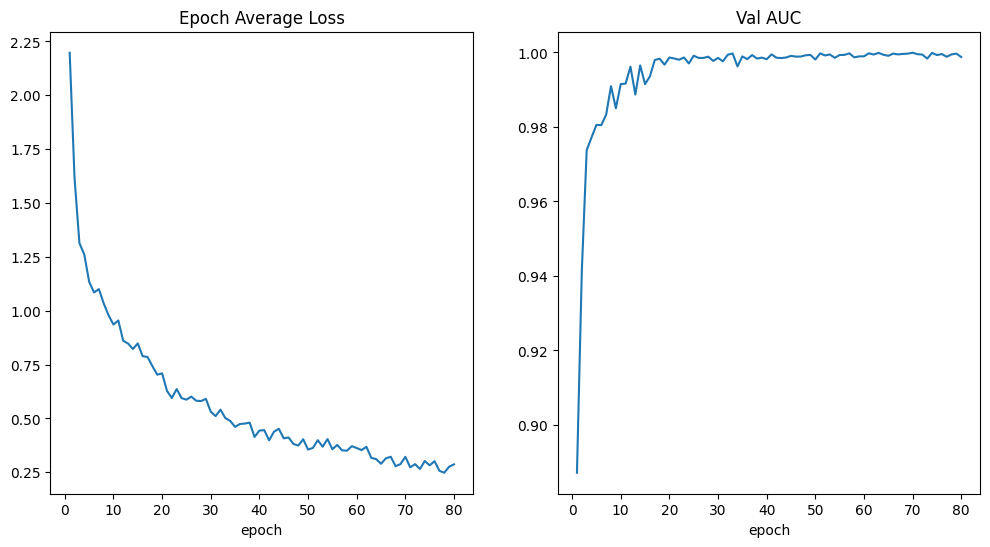

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [17]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 191.11 MB
Max VRAM used during training: 235.59 MB


### Evaluation

In [18]:
model.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [19]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 191.10 MB
Max VRAM used during training: 235.64 MB


In [20]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)

In [21]:
import pandas as pd
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'axial_random_pretrained_seed{seed}.csv')

In [22]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9583    1.0000    0.9787        69
           1     0.7667    0.6765    0.7188        68
           2     0.7377    0.6522    0.6923        69
           3     0.6977    0.9231    0.7947        65
           4     0.8298    0.6000    0.6964        65
           5     0.8769    0.8636    0.8702        66
           6     1.0000    0.9286    0.9630        28
           7     0.9524    0.9524    0.9524        21
           8     0.9545    1.0000    0.9767        21
           9     0.7368    0.8116    0.7724        69
          10     0.7703    0.8261    0.7972        69

    accuracy                         0.8131       610
   macro avg     0.8437    0.8395    0.8375       610
weighted avg     0.8170    0.8131    0.8103       610



## Unpretrained

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 80
val_interval = 1
auc_metric = ROCAUCMetric()

In [24]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images

        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "axial_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

----------
epoch 1/80
epoch 1 average loss: 2.0138
1


Epochs:   1%|▏         | 1/80 [00:10<13:21, 10.15s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9517 current accuracy: 0.4534 best AUC: 0.9517 at epoch: 1
----------
epoch 2/80
epoch 2 average loss: 1.5966
1


Epochs:   2%|▎         | 2/80 [00:20<13:27, 10.35s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9607 current accuracy: 0.5652 best AUC: 0.9607 at epoch: 2
----------
epoch 3/80
epoch 3 average loss: 1.3601
1


Epochs:   4%|▍         | 3/80 [00:31<13:39, 10.64s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9749 current accuracy: 0.6584 best AUC: 0.9749 at epoch: 3
----------
epoch 4/80
epoch 4 average loss: 1.2546
1


Epochs:   5%|▌         | 4/80 [00:42<13:40, 10.79s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9774 current accuracy: 0.6832 best AUC: 0.9774 at epoch: 4
----------
epoch 5/80
epoch 5 average loss: 1.1766


Epochs:   6%|▋         | 5/80 [00:53<13:20, 10.67s/it]

1
current epoch: 5 current AUC: 0.9757 current accuracy: 0.7329 best AUC: 0.9774 at epoch: 4
----------
epoch 6/80
epoch 6 average loss: 1.1215
1


Epochs:   8%|▊         | 6/80 [01:04<13:17, 10.78s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9803 current accuracy: 0.6894 best AUC: 0.9803 at epoch: 6
----------
epoch 7/80
epoch 7 average loss: 1.0035
1


Epochs:   9%|▉         | 7/80 [01:14<13:08, 10.80s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9870 current accuracy: 0.7764 best AUC: 0.9870 at epoch: 7
----------
epoch 8/80
epoch 8 average loss: 0.9905
1


Epochs:  10%|█         | 8/80 [01:26<13:04, 10.90s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9890 current accuracy: 0.7578 best AUC: 0.9890 at epoch: 8
----------
epoch 9/80
epoch 9 average loss: 0.9738
1


Epochs:  11%|█▏        | 9/80 [01:36<12:46, 10.80s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9892 current accuracy: 0.7329 best AUC: 0.9892 at epoch: 9
----------
epoch 10/80
epoch 10 average loss: 0.8703
1


Epochs:  12%|█▎        | 10/80 [01:46<12:24, 10.63s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9902 current accuracy: 0.8509 best AUC: 0.9902 at epoch: 10
----------
epoch 11/80
epoch 11 average loss: 0.9401
1


Epochs:  14%|█▍        | 11/80 [01:57<12:13, 10.64s/it]

saved new best metric model
current epoch: 11 current AUC: 0.9942 current accuracy: 0.8509 best AUC: 0.9942 at epoch: 11
----------
epoch 12/80
epoch 12 average loss: 0.8983


Epochs:  15%|█▌        | 12/80 [02:07<11:52, 10.47s/it]

1
current epoch: 12 current AUC: 0.9900 current accuracy: 0.7391 best AUC: 0.9942 at epoch: 11
----------
epoch 13/80
epoch 13 average loss: 0.7840


Epochs:  16%|█▋        | 13/80 [02:17<11:37, 10.41s/it]

1
current epoch: 13 current AUC: 0.9902 current accuracy: 0.8137 best AUC: 0.9942 at epoch: 11
----------
epoch 14/80
epoch 14 average loss: 0.7766


Epochs:  18%|█▊        | 14/80 [02:27<11:18, 10.28s/it]

1
current epoch: 14 current AUC: 0.9931 current accuracy: 0.8385 best AUC: 0.9942 at epoch: 11
----------
epoch 15/80
epoch 15 average loss: 0.7310
1


Epochs:  19%|█▉        | 15/80 [02:38<11:21, 10.49s/it]

saved new best metric model
current epoch: 15 current AUC: 0.9973 current accuracy: 0.9130 best AUC: 0.9973 at epoch: 15
----------
epoch 16/80
epoch 16 average loss: 0.7325


Epochs:  20%|██        | 16/80 [02:49<11:06, 10.42s/it]

1
current epoch: 16 current AUC: 0.9921 current accuracy: 0.7950 best AUC: 0.9973 at epoch: 15
----------
epoch 17/80
epoch 17 average loss: 0.7423


Epochs:  21%|██▏       | 17/80 [02:59<10:53, 10.38s/it]

1
current epoch: 17 current AUC: 0.9955 current accuracy: 0.8820 best AUC: 0.9973 at epoch: 15
----------
epoch 18/80
epoch 18 average loss: 0.7183


Epochs:  22%|██▎       | 18/80 [03:09<10:37, 10.29s/it]

1
current epoch: 18 current AUC: 0.9927 current accuracy: 0.8820 best AUC: 0.9973 at epoch: 15
----------
epoch 19/80
epoch 19 average loss: 0.7087


Epochs:  24%|██▍       | 19/80 [03:19<10:25, 10.25s/it]

1
current epoch: 19 current AUC: 0.9951 current accuracy: 0.8634 best AUC: 0.9973 at epoch: 15
----------
epoch 20/80
epoch 20 average loss: 0.7335


Epochs:  25%|██▌       | 20/80 [03:30<10:17, 10.29s/it]

1
current epoch: 20 current AUC: 0.9970 current accuracy: 0.8758 best AUC: 0.9973 at epoch: 15
----------
epoch 21/80
epoch 21 average loss: 0.6157


Epochs:  26%|██▋       | 21/80 [03:40<10:04, 10.25s/it]

1
current epoch: 21 current AUC: 0.9933 current accuracy: 0.8447 best AUC: 0.9973 at epoch: 15
----------
epoch 22/80
epoch 22 average loss: 0.6423


Epochs:  28%|██▊       | 22/80 [03:50<09:53, 10.23s/it]

1
current epoch: 22 current AUC: 0.9963 current accuracy: 0.8261 best AUC: 0.9973 at epoch: 15
----------
epoch 23/80
epoch 23 average loss: 0.6190
1


Epochs:  29%|██▉       | 23/80 [04:01<09:50, 10.35s/it]

saved new best metric model
current epoch: 23 current AUC: 0.9976 current accuracy: 0.9255 best AUC: 0.9976 at epoch: 23
----------
epoch 24/80
epoch 24 average loss: 0.6212


Epochs:  30%|███       | 24/80 [04:11<09:38, 10.34s/it]

1
current epoch: 24 current AUC: 0.9954 current accuracy: 0.8571 best AUC: 0.9976 at epoch: 23
----------
epoch 25/80
epoch 25 average loss: 0.6431


Epochs:  31%|███▏      | 25/80 [04:21<09:24, 10.27s/it]

1
current epoch: 25 current AUC: 0.9942 current accuracy: 0.8882 best AUC: 0.9976 at epoch: 23
----------
epoch 26/80
epoch 26 average loss: 0.5941
1


Epochs:  32%|███▎      | 26/80 [04:31<09:19, 10.36s/it]

saved new best metric model
current epoch: 26 current AUC: 0.9985 current accuracy: 0.9627 best AUC: 0.9985 at epoch: 26
----------
epoch 27/80
epoch 27 average loss: 0.5710


Epochs:  34%|███▍      | 27/80 [04:42<09:08, 10.34s/it]

1
current epoch: 27 current AUC: 0.9974 current accuracy: 0.9130 best AUC: 0.9985 at epoch: 26
----------
epoch 28/80
epoch 28 average loss: 0.5869


Epochs:  35%|███▌      | 28/80 [04:52<08:55, 10.30s/it]

1
current epoch: 28 current AUC: 0.9945 current accuracy: 0.8696 best AUC: 0.9985 at epoch: 26
----------
epoch 29/80
epoch 29 average loss: 0.5817
1


Epochs:  36%|███▋      | 29/80 [05:03<08:51, 10.42s/it]

saved new best metric model
current epoch: 29 current AUC: 0.9985 current accuracy: 0.9441 best AUC: 0.9985 at epoch: 29
----------
epoch 30/80
epoch 30 average loss: 0.5723


Epochs:  38%|███▊      | 30/80 [05:13<08:35, 10.31s/it]

1
current epoch: 30 current AUC: 0.9949 current accuracy: 0.8199 best AUC: 0.9985 at epoch: 29
----------
epoch 31/80
epoch 31 average loss: 0.5465


Epochs:  39%|███▉      | 31/80 [05:23<08:21, 10.23s/it]

1
current epoch: 31 current AUC: 0.9982 current accuracy: 0.9006 best AUC: 0.9985 at epoch: 29
----------
epoch 32/80
epoch 32 average loss: 0.5021


Epochs:  40%|████      | 32/80 [05:33<08:04, 10.08s/it]

1
current epoch: 32 current AUC: 0.9968 current accuracy: 0.8882 best AUC: 0.9985 at epoch: 29
----------
epoch 33/80
epoch 33 average loss: 0.5301
1


Epochs:  41%|████▏     | 33/80 [05:43<08:04, 10.30s/it]

saved new best metric model
current epoch: 33 current AUC: 0.9989 current accuracy: 0.9317 best AUC: 0.9989 at epoch: 33
----------
epoch 34/80
epoch 34 average loss: 0.5674


Epochs:  42%|████▎     | 34/80 [05:53<07:48, 10.18s/it]

1
current epoch: 34 current AUC: 0.9980 current accuracy: 0.9193 best AUC: 0.9989 at epoch: 33
----------
epoch 35/80
epoch 35 average loss: 0.5090


Epochs:  44%|████▍     | 35/80 [06:03<07:36, 10.14s/it]

1
current epoch: 35 current AUC: 0.9977 current accuracy: 0.9193 best AUC: 0.9989 at epoch: 33
----------
epoch 36/80
epoch 36 average loss: 0.5117


Epochs:  45%|████▌     | 36/80 [06:13<07:23, 10.09s/it]

1
current epoch: 36 current AUC: 0.9967 current accuracy: 0.9317 best AUC: 0.9989 at epoch: 33
----------
epoch 37/80
epoch 37 average loss: 0.5161


Epochs:  46%|████▋     | 37/80 [06:23<07:13, 10.08s/it]

1
current epoch: 37 current AUC: 0.9902 current accuracy: 0.8075 best AUC: 0.9989 at epoch: 33
----------
epoch 38/80
epoch 38 average loss: 0.5271
1


Epochs:  48%|████▊     | 38/80 [06:34<07:10, 10.26s/it]

saved new best metric model
current epoch: 38 current AUC: 0.9990 current accuracy: 0.9565 best AUC: 0.9990 at epoch: 38
----------
epoch 39/80
epoch 39 average loss: 0.4979


Epochs:  49%|████▉     | 39/80 [06:44<06:57, 10.18s/it]

1
current epoch: 39 current AUC: 0.9986 current accuracy: 0.9255 best AUC: 0.9990 at epoch: 38
----------
epoch 40/80
epoch 40 average loss: 0.4759


Epochs:  50%|█████     | 40/80 [06:54<06:44, 10.12s/it]

1
current epoch: 40 current AUC: 0.9980 current accuracy: 0.9193 best AUC: 0.9990 at epoch: 38
----------
epoch 41/80
epoch 41 average loss: 0.4733


Epochs:  51%|█████▏    | 41/80 [07:04<06:36, 10.17s/it]

1
current epoch: 41 current AUC: 0.9970 current accuracy: 0.9193 best AUC: 0.9990 at epoch: 38
----------
epoch 42/80
epoch 42 average loss: 0.4721


Epochs:  52%|█████▎    | 42/80 [07:14<06:23, 10.10s/it]

1
current epoch: 42 current AUC: 0.9976 current accuracy: 0.8944 best AUC: 0.9990 at epoch: 38
----------
epoch 43/80
epoch 43 average loss: 0.4488


Epochs:  54%|█████▍    | 43/80 [07:24<06:16, 10.16s/it]

1
current epoch: 43 current AUC: 0.9969 current accuracy: 0.9068 best AUC: 0.9990 at epoch: 38
----------
epoch 44/80
epoch 44 average loss: 0.5080
1


Epochs:  55%|█████▌    | 44/80 [07:35<06:09, 10.26s/it]

saved new best metric model
current epoch: 44 current AUC: 0.9991 current accuracy: 0.9068 best AUC: 0.9991 at epoch: 44
----------
epoch 45/80
epoch 45 average loss: 0.4451
1


Epochs:  56%|█████▋    | 45/80 [07:45<06:01, 10.32s/it]

saved new best metric model
current epoch: 45 current AUC: 0.9994 current accuracy: 0.9317 best AUC: 0.9994 at epoch: 45
----------
epoch 46/80
epoch 46 average loss: 0.4442


Epochs:  57%|█████▊    | 46/80 [07:55<05:46, 10.19s/it]

1
current epoch: 46 current AUC: 0.9983 current accuracy: 0.9255 best AUC: 0.9994 at epoch: 45
----------
epoch 47/80
epoch 47 average loss: 0.4406
1


Epochs:  59%|█████▉    | 47/80 [08:06<05:38, 10.25s/it]

saved new best metric model
current epoch: 47 current AUC: 0.9995 current accuracy: 0.9503 best AUC: 0.9995 at epoch: 47
----------
epoch 48/80
epoch 48 average loss: 0.4527


Epochs:  60%|██████    | 48/80 [08:16<05:25, 10.17s/it]

1
current epoch: 48 current AUC: 0.9983 current accuracy: 0.8944 best AUC: 0.9995 at epoch: 47
----------
epoch 49/80
epoch 49 average loss: 0.4368


Epochs:  61%|██████▏   | 49/80 [08:26<05:13, 10.12s/it]

1
current epoch: 49 current AUC: 0.9979 current accuracy: 0.9317 best AUC: 0.9995 at epoch: 47
----------
epoch 50/80
epoch 50 average loss: 0.4523


Epochs:  62%|██████▎   | 50/80 [08:36<05:03, 10.12s/it]

1
current epoch: 50 current AUC: 0.9961 current accuracy: 0.9068 best AUC: 0.9995 at epoch: 47
----------
epoch 51/80
epoch 51 average loss: 0.4469


Epochs:  64%|██████▍   | 51/80 [08:46<04:52, 10.08s/it]

1
current epoch: 51 current AUC: 0.9972 current accuracy: 0.9317 best AUC: 0.9995 at epoch: 47
----------
epoch 52/80
epoch 52 average loss: 0.3889


Epochs:  65%|██████▌   | 52/80 [08:56<04:41, 10.06s/it]

1
current epoch: 52 current AUC: 0.9960 current accuracy: 0.9255 best AUC: 0.9995 at epoch: 47
----------
epoch 53/80
epoch 53 average loss: 0.4358


Epochs:  66%|██████▋   | 53/80 [09:06<04:33, 10.12s/it]

1
current epoch: 53 current AUC: 0.9960 current accuracy: 0.8820 best AUC: 0.9995 at epoch: 47
----------
epoch 54/80
epoch 54 average loss: 0.3664


Epochs:  68%|██████▊   | 54/80 [09:16<04:22, 10.11s/it]

1
current epoch: 54 current AUC: 0.9993 current accuracy: 0.9379 best AUC: 0.9995 at epoch: 47
----------
epoch 55/80
epoch 55 average loss: 0.4067


Epochs:  69%|██████▉   | 55/80 [09:26<04:13, 10.16s/it]

1
current epoch: 55 current AUC: 0.9991 current accuracy: 0.9255 best AUC: 0.9995 at epoch: 47
----------
epoch 56/80
epoch 56 average loss: 0.4027


Epochs:  70%|███████   | 56/80 [09:36<04:02, 10.10s/it]

1
current epoch: 56 current AUC: 0.9973 current accuracy: 0.9006 best AUC: 0.9995 at epoch: 47
----------
epoch 57/80
epoch 57 average loss: 0.4214


Epochs:  71%|███████▏  | 57/80 [09:47<03:53, 10.14s/it]

1
current epoch: 57 current AUC: 0.9981 current accuracy: 0.9130 best AUC: 0.9995 at epoch: 47
----------
epoch 58/80
epoch 58 average loss: 0.3648


Epochs:  72%|███████▎  | 58/80 [09:56<03:41, 10.06s/it]

1
current epoch: 58 current AUC: 0.9990 current accuracy: 0.9379 best AUC: 0.9995 at epoch: 47
----------
epoch 59/80
epoch 59 average loss: 0.3941


Epochs:  74%|███████▍  | 59/80 [10:07<03:32, 10.11s/it]

1
current epoch: 59 current AUC: 0.9945 current accuracy: 0.9503 best AUC: 0.9995 at epoch: 47
----------
epoch 60/80
epoch 60 average loss: 0.3288


Epochs:  75%|███████▌  | 60/80 [10:17<03:23, 10.17s/it]

1
current epoch: 60 current AUC: 0.9995 current accuracy: 0.9565 best AUC: 0.9995 at epoch: 47
----------
epoch 61/80
epoch 61 average loss: 0.3868


Epochs:  76%|███████▋  | 61/80 [10:27<03:12, 10.15s/it]

1
current epoch: 61 current AUC: 0.9991 current accuracy: 0.9006 best AUC: 0.9995 at epoch: 47
----------
epoch 62/80
epoch 62 average loss: 0.3450


Epochs:  78%|███████▊  | 62/80 [10:37<03:03, 10.18s/it]

1
current epoch: 62 current AUC: 0.9950 current accuracy: 0.8882 best AUC: 0.9995 at epoch: 47
----------
epoch 63/80
epoch 63 average loss: 0.3720


Epochs:  79%|███████▉  | 63/80 [10:47<02:52, 10.13s/it]

1
current epoch: 63 current AUC: 0.9987 current accuracy: 0.9441 best AUC: 0.9995 at epoch: 47
----------
epoch 64/80
epoch 64 average loss: 0.3559


Epochs:  80%|████████  | 64/80 [10:58<02:41, 10.12s/it]

1
current epoch: 64 current AUC: 0.9970 current accuracy: 0.8696 best AUC: 0.9995 at epoch: 47
----------
epoch 65/80
epoch 65 average loss: 0.3420


Epochs:  81%|████████▏ | 65/80 [11:08<02:31, 10.10s/it]

1
current epoch: 65 current AUC: 0.9988 current accuracy: 0.9006 best AUC: 0.9995 at epoch: 47
----------
epoch 66/80
epoch 66 average loss: 0.3358


Epochs:  82%|████████▎ | 66/80 [11:17<02:20, 10.03s/it]

1
current epoch: 66 current AUC: 0.9986 current accuracy: 0.9503 best AUC: 0.9995 at epoch: 47
----------
epoch 67/80
epoch 67 average loss: 0.3302


Epochs:  84%|████████▍ | 67/80 [11:27<02:09,  9.97s/it]

1
current epoch: 67 current AUC: 0.9991 current accuracy: 0.9068 best AUC: 0.9995 at epoch: 47
----------
epoch 68/80
epoch 68 average loss: 0.2780


Epochs:  85%|████████▌ | 68/80 [11:37<01:58,  9.85s/it]

1
current epoch: 68 current AUC: 0.9993 current accuracy: 0.9255 best AUC: 0.9995 at epoch: 47
----------
epoch 69/80
epoch 69 average loss: 0.3156


Epochs:  86%|████████▋ | 69/80 [11:46<01:47,  9.78s/it]

1
current epoch: 69 current AUC: 0.9993 current accuracy: 0.8758 best AUC: 0.9995 at epoch: 47
----------
epoch 70/80
epoch 70 average loss: 0.3344


Epochs:  88%|████████▊ | 70/80 [11:56<01:36,  9.64s/it]

1
current epoch: 70 current AUC: 0.9988 current accuracy: 0.9379 best AUC: 0.9995 at epoch: 47
----------
epoch 71/80
epoch 71 average loss: 0.3290


Epochs:  89%|████████▉ | 71/80 [12:05<01:26,  9.64s/it]

1
current epoch: 71 current AUC: 0.9990 current accuracy: 0.9565 best AUC: 0.9995 at epoch: 47
----------
epoch 72/80
epoch 72 average loss: 0.3455


Epochs:  90%|█████████ | 72/80 [12:15<01:17,  9.63s/it]

1
current epoch: 72 current AUC: 0.9930 current accuracy: 0.8199 best AUC: 0.9995 at epoch: 47
----------
epoch 73/80
epoch 73 average loss: 0.3679


Epochs:  91%|█████████▏| 73/80 [12:25<01:07,  9.61s/it]

1
current epoch: 73 current AUC: 0.9941 current accuracy: 0.8261 best AUC: 0.9995 at epoch: 47
----------
epoch 74/80
epoch 74 average loss: 0.3659


Epochs:  92%|█████████▎| 74/80 [12:34<00:57,  9.62s/it]

1
current epoch: 74 current AUC: 0.9992 current accuracy: 0.9379 best AUC: 0.9995 at epoch: 47
----------
epoch 75/80
epoch 75 average loss: 0.3251


Epochs:  94%|█████████▍| 75/80 [12:44<00:47,  9.53s/it]

1
current epoch: 75 current AUC: 0.9987 current accuracy: 0.9752 best AUC: 0.9995 at epoch: 47
----------
epoch 76/80
epoch 76 average loss: 0.2654


Epochs:  95%|█████████▌| 76/80 [12:53<00:38,  9.51s/it]

1
current epoch: 76 current AUC: 0.9992 current accuracy: 0.9441 best AUC: 0.9995 at epoch: 47
----------
epoch 77/80
epoch 77 average loss: 0.2704


Epochs:  96%|█████████▋| 77/80 [13:03<00:28,  9.53s/it]

1
current epoch: 77 current AUC: 0.9990 current accuracy: 0.9255 best AUC: 0.9995 at epoch: 47
----------
epoch 78/80
epoch 78 average loss: 0.3057


Epochs:  98%|█████████▊| 78/80 [13:12<00:19,  9.54s/it]

1
current epoch: 78 current AUC: 0.9991 current accuracy: 0.9689 best AUC: 0.9995 at epoch: 47
----------
epoch 79/80
epoch 79 average loss: 0.2856


Epochs:  99%|█████████▉| 79/80 [13:22<00:09,  9.60s/it]

1
current epoch: 79 current AUC: 0.9979 current accuracy: 0.9503 best AUC: 0.9995 at epoch: 47
----------
epoch 80/80
epoch 80 average loss: 0.3036
1


Epochs: 100%|██████████| 80/80 [13:32<00:00, 10.15s/it]

saved new best metric model
current epoch: 80 current AUC: 0.9997 current accuracy: 0.9627 best AUC: 0.9997 at epoch: 80
train completed, best_metric: 0.9997 at epoch: 80


In [25]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 812.39 seconds
CPU time used: 9673.00 seconds
Memory used: 391.15 MB
GPU Memory Used: 192.63 MB
Max GPU Memory Used: 247.71 MB


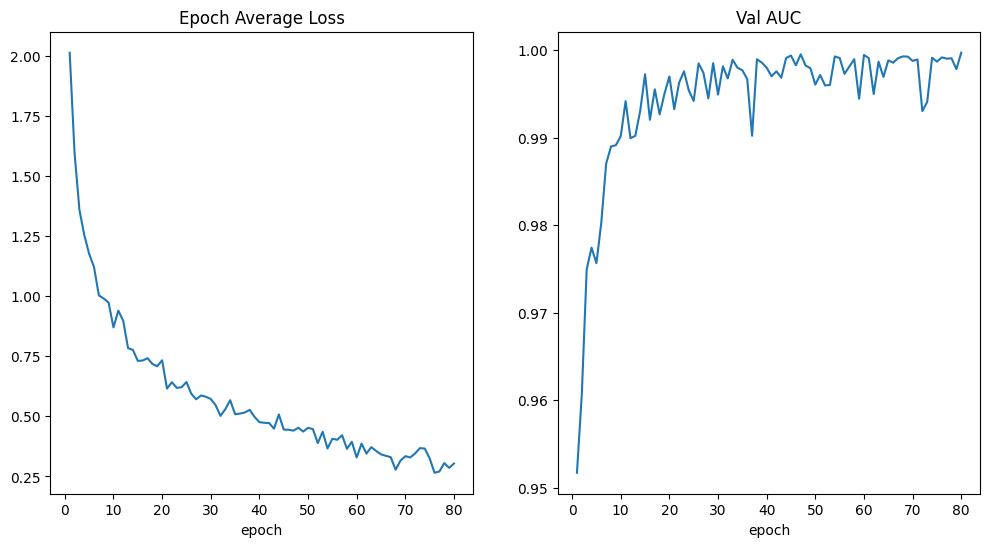

In [26]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [27]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 192.62 MB
Max VRAM used during training: 247.71 MB


### Evaluation

In [28]:
model.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [29]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)

In [30]:
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'axial_random_unpretrained_seed{seed}.csv')

In [31]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9714    0.9855    0.9784        69
           1     0.7742    0.7059    0.7385        68
           2     0.8197    0.7246    0.7692        69
           3     0.8143    0.8769    0.8444        65
           4     0.9216    0.7231    0.8103        65
           5     0.8500    0.7727    0.8095        66
           6     0.7941    0.9643    0.8710        28
           7     0.9048    0.9048    0.9048        21
           8     0.9091    0.9524    0.9302        21
           9     0.8594    0.7971    0.8271        69
          10     0.7053    0.9710    0.8171        69

    accuracy                         0.8344       610
   macro avg     0.8476    0.8526    0.8455       610
weighted avg     0.8417    0.8344    0.8331       610



In [32]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 192.63 MB
Max VRAM used during training: 247.71 MB


# Coronal and sagittal parts

## Training cycle for the coronal part

## Pretrained

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(9, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 80
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# best_metric = -1
# best_metric_epoch = -1
# epoch_loss_values = []
# metric_values = []
# writer = SummaryWriter()

# start_time = time.time()
# process = psutil.Process()
# start_cpu = process.cpu_times()
# start_mem = process.memory_info().rss / 1024**2

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "coronal_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

----------
epoch 1/80
epoch 1 average loss: 1.9937


Epochs:   1%|▏         | 1/80 [00:09<11:51,  9.01s/it]

1
current epoch: 1 current AUC: 0.8945 current accuracy: 0.4658 best AUC: 0.9997 at epoch: 80
----------
epoch 2/80
epoch 2 average loss: 1.4488


Epochs:   2%|▎         | 2/80 [00:18<11:47,  9.07s/it]

1
current epoch: 2 current AUC: 0.9582 current accuracy: 0.6957 best AUC: 0.9997 at epoch: 80
----------
epoch 3/80
epoch 3 average loss: 1.1435


Epochs:   4%|▍         | 3/80 [00:27<11:38,  9.08s/it]

1
current epoch: 3 current AUC: 0.9892 current accuracy: 0.8509 best AUC: 0.9997 at epoch: 80
----------
epoch 4/80
epoch 4 average loss: 1.0162


Epochs:   5%|▌         | 4/80 [00:36<11:29,  9.08s/it]

1
current epoch: 4 current AUC: 0.9893 current accuracy: 0.8571 best AUC: 0.9997 at epoch: 80
----------
epoch 5/80
epoch 5 average loss: 0.9057


Epochs:   6%|▋         | 5/80 [00:45<11:19,  9.07s/it]

1
current epoch: 5 current AUC: 0.9911 current accuracy: 0.8509 best AUC: 0.9997 at epoch: 80
----------
epoch 6/80
epoch 6 average loss: 0.8739


Epochs:   8%|▊         | 6/80 [00:54<11:10,  9.06s/it]

1
current epoch: 6 current AUC: 0.9958 current accuracy: 0.9130 best AUC: 0.9997 at epoch: 80
----------
epoch 7/80
epoch 7 average loss: 0.8532


Epochs:   9%|▉         | 7/80 [01:03<11:02,  9.08s/it]

1
current epoch: 7 current AUC: 0.9974 current accuracy: 0.9130 best AUC: 0.9997 at epoch: 80
----------
epoch 8/80
epoch 8 average loss: 0.7239


Epochs:  10%|█         | 8/80 [01:12<10:55,  9.11s/it]

1
current epoch: 8 current AUC: 0.9991 current accuracy: 0.9379 best AUC: 0.9997 at epoch: 80
----------
epoch 9/80
epoch 9 average loss: 0.6745


Epochs:  11%|█▏        | 9/80 [01:21<10:45,  9.09s/it]

1
current epoch: 9 current AUC: 0.9990 current accuracy: 0.9441 best AUC: 0.9997 at epoch: 80
----------
epoch 10/80
epoch 10 average loss: 0.6552


Epochs:  12%|█▎        | 10/80 [01:30<10:34,  9.07s/it]

1
current epoch: 10 current AUC: 0.9938 current accuracy: 0.9130 best AUC: 0.9997 at epoch: 80
----------
epoch 11/80
epoch 11 average loss: 0.6679


Epochs:  14%|█▍        | 11/80 [01:39<10:25,  9.06s/it]

1
current epoch: 11 current AUC: 0.9972 current accuracy: 0.9255 best AUC: 0.9997 at epoch: 80
----------
epoch 12/80
epoch 12 average loss: 0.6029


Epochs:  15%|█▌        | 12/80 [01:48<10:16,  9.07s/it]

1
current epoch: 12 current AUC: 0.9995 current accuracy: 0.9752 best AUC: 0.9997 at epoch: 80
----------
epoch 13/80
epoch 13 average loss: 0.5958


Epochs:  16%|█▋        | 13/80 [01:57<10:05,  9.04s/it]

1
current epoch: 13 current AUC: 0.9985 current accuracy: 0.9503 best AUC: 0.9997 at epoch: 80
----------
epoch 14/80
epoch 14 average loss: 0.5248


Epochs:  18%|█▊        | 14/80 [02:07<09:58,  9.07s/it]

1
current epoch: 14 current AUC: 0.9989 current accuracy: 0.9565 best AUC: 0.9997 at epoch: 80
----------
epoch 15/80
epoch 15 average loss: 0.5366


Epochs:  19%|█▉        | 15/80 [02:16<09:48,  9.06s/it]

1
current epoch: 15 current AUC: 0.9991 current accuracy: 0.9689 best AUC: 0.9997 at epoch: 80
----------
epoch 16/80
epoch 16 average loss: 0.5658


Epochs:  20%|██        | 16/80 [02:25<09:39,  9.06s/it]

1
current epoch: 16 current AUC: 0.9977 current accuracy: 0.9379 best AUC: 0.9997 at epoch: 80
----------
epoch 17/80
epoch 17 average loss: 0.5450


Epochs:  21%|██▏       | 17/80 [02:34<09:32,  9.08s/it]

1
current epoch: 17 current AUC: 0.9975 current accuracy: 0.9255 best AUC: 0.9997 at epoch: 80
----------
epoch 18/80
epoch 18 average loss: 0.5065


Epochs:  22%|██▎       | 18/80 [02:43<09:20,  9.04s/it]

1
current epoch: 18 current AUC: 0.9994 current accuracy: 0.9565 best AUC: 0.9997 at epoch: 80
----------
epoch 19/80
epoch 19 average loss: 0.4561
1


Epochs:  24%|██▍       | 19/80 [02:52<09:20,  9.18s/it]

saved new best metric model
current epoch: 19 current AUC: 0.9997 current accuracy: 0.9752 best AUC: 0.9997 at epoch: 19
----------
epoch 20/80
epoch 20 average loss: 0.4684


Epochs:  25%|██▌       | 20/80 [03:01<09:09,  9.16s/it]

1
current epoch: 20 current AUC: 0.9946 current accuracy: 0.8882 best AUC: 0.9997 at epoch: 19
----------
epoch 21/80
epoch 21 average loss: 0.4876


Epochs:  26%|██▋       | 21/80 [03:10<08:59,  9.14s/it]

1
current epoch: 21 current AUC: 0.9993 current accuracy: 0.9689 best AUC: 0.9997 at epoch: 19
----------
epoch 22/80
epoch 22 average loss: 0.3748


Epochs:  28%|██▊       | 22/80 [03:20<08:50,  9.15s/it]

1
current epoch: 22 current AUC: 0.9997 current accuracy: 0.9814 best AUC: 0.9997 at epoch: 19
----------
epoch 23/80
epoch 23 average loss: 0.4501


Epochs:  29%|██▉       | 23/80 [03:29<08:42,  9.16s/it]

1
current epoch: 23 current AUC: 0.9988 current accuracy: 0.9627 best AUC: 0.9997 at epoch: 19
----------
epoch 24/80
epoch 24 average loss: 0.4227


Epochs:  30%|███       | 24/80 [03:38<08:31,  9.14s/it]

1
current epoch: 24 current AUC: 0.9997 current accuracy: 0.9689 best AUC: 0.9997 at epoch: 19
----------
epoch 25/80
epoch 25 average loss: 0.4051


Epochs:  31%|███▏      | 25/80 [03:47<08:22,  9.14s/it]

1
current epoch: 25 current AUC: 0.9996 current accuracy: 0.9752 best AUC: 0.9997 at epoch: 19
----------
epoch 26/80
epoch 26 average loss: 0.4538


Epochs:  32%|███▎      | 26/80 [03:56<08:12,  9.13s/it]

1
current epoch: 26 current AUC: 0.9993 current accuracy: 0.9441 best AUC: 0.9997 at epoch: 19
----------
epoch 27/80
epoch 27 average loss: 0.4113


Epochs:  34%|███▍      | 27/80 [04:05<08:02,  9.10s/it]

1
current epoch: 27 current AUC: 0.9974 current accuracy: 0.9379 best AUC: 0.9997 at epoch: 19
----------
epoch 28/80
epoch 28 average loss: 0.3662


Epochs:  35%|███▌      | 28/80 [04:14<07:52,  9.09s/it]

1
current epoch: 28 current AUC: 0.9996 current accuracy: 0.9752 best AUC: 0.9997 at epoch: 19
----------
epoch 29/80
epoch 29 average loss: 0.3625
1


Epochs:  36%|███▋      | 29/80 [04:24<07:50,  9.23s/it]

saved new best metric model
current epoch: 29 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 29
----------
epoch 30/80
epoch 30 average loss: 0.3532


Epochs:  38%|███▊      | 30/80 [04:33<07:39,  9.20s/it]

1
current epoch: 30 current AUC: 0.9994 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 29
----------
epoch 31/80
epoch 31 average loss: 0.3691


Epochs:  39%|███▉      | 31/80 [04:42<07:27,  9.14s/it]

1
current epoch: 31 current AUC: 0.9992 current accuracy: 0.9503 best AUC: 0.9999 at epoch: 29
----------
epoch 32/80
epoch 32 average loss: 0.3940


Epochs:  40%|████      | 32/80 [04:51<07:18,  9.13s/it]

1
current epoch: 32 current AUC: 0.9997 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 29
----------
epoch 33/80
epoch 33 average loss: 0.3721


Epochs:  41%|████▏     | 33/80 [05:00<07:09,  9.13s/it]

1
current epoch: 33 current AUC: 0.9996 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 29
----------
epoch 34/80
epoch 34 average loss: 0.3180


Epochs:  42%|████▎     | 34/80 [05:09<06:58,  9.10s/it]

1
current epoch: 34 current AUC: 0.9992 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 29
----------
epoch 35/80
epoch 35 average loss: 0.4029


Epochs:  44%|████▍     | 35/80 [05:18<06:48,  9.08s/it]

1
current epoch: 35 current AUC: 0.9995 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 29
----------
epoch 36/80
epoch 36 average loss: 0.3763


Epochs:  45%|████▌     | 36/80 [05:28<06:45,  9.22s/it]

1
current epoch: 36 current AUC: 0.9997 current accuracy: 0.9876 best AUC: 0.9999 at epoch: 29
----------
epoch 37/80
epoch 37 average loss: 0.3600


Epochs:  46%|████▋     | 37/80 [05:37<06:33,  9.15s/it]

1
current epoch: 37 current AUC: 0.9996 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 29
----------
epoch 38/80
epoch 38 average loss: 0.3019


Epochs:  48%|████▊     | 38/80 [05:46<06:23,  9.14s/it]

1
current epoch: 38 current AUC: 0.9992 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 29
----------
epoch 39/80
epoch 39 average loss: 0.3462


Epochs:  49%|████▉     | 39/80 [05:55<06:13,  9.12s/it]

1
current epoch: 39 current AUC: 0.9994 current accuracy: 0.9627 best AUC: 0.9999 at epoch: 29
----------
epoch 40/80
epoch 40 average loss: 0.3241


Epochs:  50%|█████     | 40/80 [06:04<06:03,  9.10s/it]

1
current epoch: 40 current AUC: 0.9982 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 29
----------
epoch 41/80
epoch 41 average loss: 0.3160


Epochs:  51%|█████▏    | 41/80 [06:13<05:54,  9.08s/it]

1
current epoch: 41 current AUC: 0.9998 current accuracy: 0.9752 best AUC: 0.9999 at epoch: 29
----------
epoch 42/80
epoch 42 average loss: 0.2579


Epochs:  52%|█████▎    | 42/80 [06:22<05:45,  9.10s/it]

1
current epoch: 42 current AUC: 0.9985 current accuracy: 0.9379 best AUC: 0.9999 at epoch: 29
----------
epoch 43/80
epoch 43 average loss: 0.2872


Epochs:  54%|█████▍    | 43/80 [06:31<05:37,  9.11s/it]

1
current epoch: 43 current AUC: 0.9996 current accuracy: 0.9876 best AUC: 0.9999 at epoch: 29
----------
epoch 44/80
epoch 44 average loss: 0.2732


Epochs:  55%|█████▌    | 44/80 [06:40<05:26,  9.08s/it]

1
current epoch: 44 current AUC: 0.9986 current accuracy: 0.9503 best AUC: 0.9999 at epoch: 29
----------
epoch 45/80
epoch 45 average loss: 0.2802


Epochs:  56%|█████▋    | 45/80 [06:49<05:18,  9.09s/it]

1
current epoch: 45 current AUC: 0.9987 current accuracy: 0.9876 best AUC: 0.9999 at epoch: 29
----------
epoch 46/80
epoch 46 average loss: 0.2616


Epochs:  57%|█████▊    | 46/80 [06:58<05:08,  9.08s/it]

1
current epoch: 46 current AUC: 0.9998 current accuracy: 0.9752 best AUC: 0.9999 at epoch: 29
----------
epoch 47/80
epoch 47 average loss: 0.2890


Epochs:  59%|█████▉    | 47/80 [07:08<04:59,  9.09s/it]

1
current epoch: 47 current AUC: 0.9993 current accuracy: 0.9752 best AUC: 0.9999 at epoch: 29
----------
epoch 48/80
epoch 48 average loss: 0.2683


Epochs:  60%|██████    | 48/80 [07:17<04:50,  9.08s/it]

1
current epoch: 48 current AUC: 0.9994 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 29
----------
epoch 49/80
epoch 49 average loss: 0.3132


Epochs:  61%|██████▏   | 49/80 [07:26<04:41,  9.07s/it]

1
current epoch: 49 current AUC: 0.9993 current accuracy: 0.9627 best AUC: 0.9999 at epoch: 29
----------
epoch 50/80
epoch 50 average loss: 0.2543


Epochs:  62%|██████▎   | 50/80 [07:35<04:32,  9.07s/it]

1
current epoch: 50 current AUC: 0.9994 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 29
----------
epoch 51/80
epoch 51 average loss: 0.2457


Epochs:  64%|██████▍   | 51/80 [07:44<04:23,  9.08s/it]

1
current epoch: 51 current AUC: 0.9985 current accuracy: 0.9627 best AUC: 0.9999 at epoch: 29
----------
epoch 52/80
epoch 52 average loss: 0.2481


Epochs:  65%|██████▌   | 52/80 [07:53<04:14,  9.10s/it]

1
current epoch: 52 current AUC: 0.9994 current accuracy: 0.9627 best AUC: 0.9999 at epoch: 29
----------
epoch 53/80
epoch 53 average loss: 0.3250


Epochs:  66%|██████▋   | 53/80 [08:02<04:05,  9.10s/it]

1
current epoch: 53 current AUC: 0.9994 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 29
----------
epoch 54/80
epoch 54 average loss: 0.2375


Epochs:  68%|██████▊   | 54/80 [08:11<03:56,  9.09s/it]

1
current epoch: 54 current AUC: 0.9995 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 29
----------
epoch 55/80
epoch 55 average loss: 0.2356


Epochs:  69%|██████▉   | 55/80 [08:20<03:47,  9.11s/it]

1
current epoch: 55 current AUC: 0.9992 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 29
----------
epoch 56/80
epoch 56 average loss: 0.2159
1


Epochs:  70%|███████   | 56/80 [08:30<03:41,  9.24s/it]

saved new best metric model
current epoch: 56 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 0.9999 at epoch: 56
----------
epoch 57/80
epoch 57 average loss: 0.2411


Epochs:  71%|███████▏  | 57/80 [08:39<03:31,  9.19s/it]

1
current epoch: 57 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 56
----------
epoch 58/80
epoch 58 average loss: 0.2655


Epochs:  72%|███████▎  | 58/80 [08:48<03:21,  9.16s/it]

1
current epoch: 58 current AUC: 0.9994 current accuracy: 0.9627 best AUC: 0.9999 at epoch: 56
----------
epoch 59/80
epoch 59 average loss: 0.2442


Epochs:  74%|███████▍  | 59/80 [08:57<03:13,  9.20s/it]

1
current epoch: 59 current AUC: 0.9994 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 56
----------
epoch 60/80
epoch 60 average loss: 0.2027


Epochs:  75%|███████▌  | 60/80 [09:06<03:03,  9.16s/it]

1
current epoch: 60 current AUC: 0.9997 current accuracy: 0.9938 best AUC: 0.9999 at epoch: 56
----------
epoch 61/80
epoch 61 average loss: 0.2627


Epochs:  76%|███████▋  | 61/80 [09:16<02:54,  9.16s/it]

1
current epoch: 61 current AUC: 0.9997 current accuracy: 0.9876 best AUC: 0.9999 at epoch: 56
----------
epoch 62/80
epoch 62 average loss: 0.2032


Epochs:  78%|███████▊  | 62/80 [09:25<02:44,  9.13s/it]

1
current epoch: 62 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 56
----------
epoch 63/80
epoch 63 average loss: 0.2337


Epochs:  79%|███████▉  | 63/80 [09:34<02:35,  9.13s/it]

1
current epoch: 63 current AUC: 0.9995 current accuracy: 0.9752 best AUC: 0.9999 at epoch: 56
----------
epoch 64/80
epoch 64 average loss: 0.1863


Epochs:  80%|████████  | 64/80 [09:43<02:26,  9.13s/it]

1
current epoch: 64 current AUC: 0.9998 current accuracy: 0.9752 best AUC: 0.9999 at epoch: 56
----------
epoch 65/80
epoch 65 average loss: 0.1832


Epochs:  81%|████████▏ | 65/80 [09:52<02:16,  9.11s/it]

1
current epoch: 65 current AUC: 0.9987 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 56
----------
epoch 66/80
epoch 66 average loss: 0.2229


Epochs:  82%|████████▎ | 66/80 [10:01<02:07,  9.10s/it]

1
current epoch: 66 current AUC: 0.9990 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 56
----------
epoch 67/80
epoch 67 average loss: 0.2225


Epochs:  84%|████████▍ | 67/80 [10:10<01:58,  9.08s/it]

1
current epoch: 67 current AUC: 0.9997 current accuracy: 0.9876 best AUC: 0.9999 at epoch: 56
----------
epoch 68/80
epoch 68 average loss: 0.2164


Epochs:  85%|████████▌ | 68/80 [10:19<01:48,  9.08s/it]

1
current epoch: 68 current AUC: 0.9995 current accuracy: 0.9627 best AUC: 0.9999 at epoch: 56
----------
epoch 69/80
epoch 69 average loss: 0.2206


Epochs:  86%|████████▋ | 69/80 [10:28<01:39,  9.08s/it]

1
current epoch: 69 current AUC: 0.9996 current accuracy: 0.9752 best AUC: 0.9999 at epoch: 56
----------
epoch 70/80
epoch 70 average loss: 0.2239


Epochs:  88%|████████▊ | 70/80 [10:37<01:30,  9.07s/it]

1
current epoch: 70 current AUC: 0.9989 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 56
----------
epoch 71/80
epoch 71 average loss: 0.2236
1


Epochs:  89%|████████▉ | 71/80 [10:47<01:22,  9.18s/it]

saved new best metric model
current epoch: 71 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 71
----------
epoch 72/80
epoch 72 average loss: 0.2182


Epochs:  90%|█████████ | 72/80 [10:56<01:13,  9.14s/it]

1
current epoch: 72 current AUC: 0.9998 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 71
----------
epoch 73/80
epoch 73 average loss: 0.1855


Epochs:  91%|█████████▏| 73/80 [11:05<01:03,  9.12s/it]

1
current epoch: 73 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 71
----------
epoch 74/80
epoch 74 average loss: 0.1969


Epochs:  92%|█████████▎| 74/80 [11:14<00:54,  9.15s/it]

1
current epoch: 74 current AUC: 0.9991 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 71
----------
epoch 75/80
epoch 75 average loss: 0.1681


Epochs:  94%|█████████▍| 75/80 [11:23<00:45,  9.13s/it]

1
current epoch: 75 current AUC: 0.9995 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 71
----------
epoch 76/80
epoch 76 average loss: 0.1859


Epochs:  95%|█████████▌| 76/80 [11:32<00:36,  9.10s/it]

1
current epoch: 76 current AUC: 0.9994 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 71
----------
epoch 77/80
epoch 77 average loss: 0.1911


Epochs:  96%|█████████▋| 77/80 [11:41<00:27,  9.09s/it]

1
current epoch: 77 current AUC: 0.9990 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 71
----------
epoch 78/80
epoch 78 average loss: 0.1872


Epochs:  98%|█████████▊| 78/80 [11:50<00:18,  9.06s/it]

1
current epoch: 78 current AUC: 0.9988 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 71
----------
epoch 79/80
epoch 79 average loss: 0.1633
1


Epochs:  99%|█████████▉| 79/80 [12:00<00:09,  9.21s/it]

saved new best metric model
current epoch: 79 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 79
----------
epoch 80/80
epoch 80 average loss: 0.1794


Epochs: 100%|██████████| 80/80 [12:09<00:00,  9.12s/it]

1
current epoch: 80 current AUC: 0.9991 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 79
train completed, best_metric: 1.0000 at epoch: 79


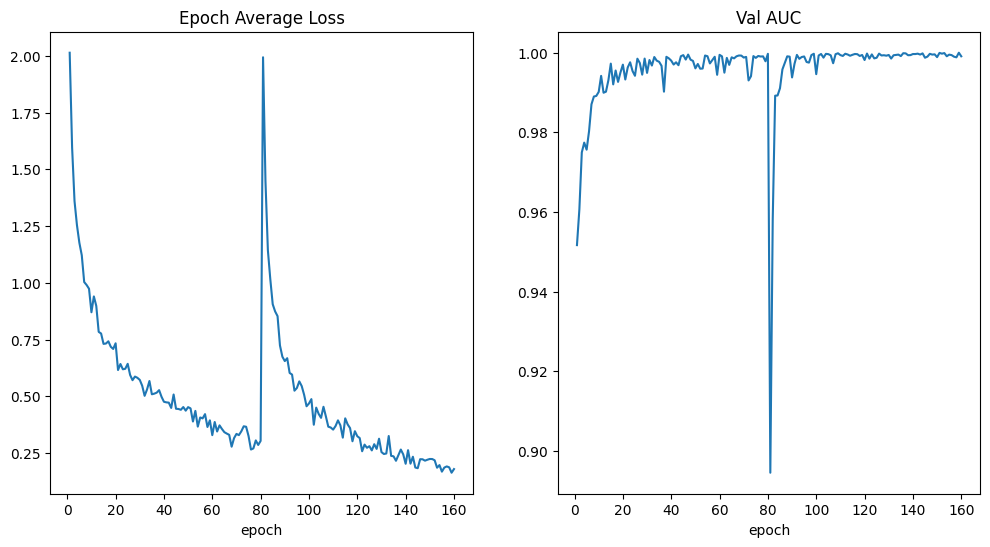

In [35]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [36]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 1543.49 seconds
CPU time used: 18422.06 seconds
Memory used: 699.59 MB
GPU Memory Used: 192.75 MB
Max GPU Memory Used: 236.35 MB


In [37]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 192.75 MB
Max VRAM used during training: 236.35 MB


### Evaluation

In [38]:
model.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_coronal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [39]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9718    1.0000    0.9857        69
           1     0.8906    0.8382    0.8636        68
           2     0.7778    0.8116    0.7943        69
           3     0.8824    0.9231    0.9023        65
           4     0.8406    0.8923    0.8657        65
           5     0.9153    0.8182    0.8640        66
           6     0.9231    0.8571    0.8889        28
           7     1.0000    0.8571    0.9231        21
           8     0.9130    1.0000    0.9545        21
           9     0.9559    0.9420    0.9489        69
          10     0.8750    0.9130    0.8936        69

    accuracy                         0.8934       610
   macro avg     0.9041    0.8957    0.8986       610
weighted avg     0.8951    0.8934    0.8933       610



In [40]:
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'coronal_random_pretrained_seed{seed}.csv')

In [41]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 192.74 MB
Max VRAM used during training: 236.40 MB


## Unpretrained

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 80
val_interval = 1
auc_metric = ROCAUCMetric()

In [43]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "coronal_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

----------
epoch 1/80
epoch 1 average loss: 1.9586
1


Epochs:   1%|▏         | 1/80 [00:10<14:27, 10.98s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9446 current accuracy: 0.5714 best AUC: 0.9446 at epoch: 1
----------
epoch 2/80
epoch 2 average loss: 1.5000
1


Epochs:   2%|▎         | 2/80 [00:22<14:28, 11.14s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9724 current accuracy: 0.6832 best AUC: 0.9724 at epoch: 2
----------
epoch 3/80
epoch 3 average loss: 1.2339
1


Epochs:   4%|▍         | 3/80 [00:33<14:21, 11.18s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9893 current accuracy: 0.8012 best AUC: 0.9893 at epoch: 3
----------
epoch 4/80
epoch 4 average loss: 1.0472


Epochs:   5%|▌         | 4/80 [00:44<13:54, 10.98s/it]

1
current epoch: 4 current AUC: 0.9795 current accuracy: 0.6957 best AUC: 0.9893 at epoch: 3
----------
epoch 5/80
epoch 5 average loss: 0.9324


Epochs:   6%|▋         | 5/80 [00:54<13:22, 10.70s/it]

1
current epoch: 5 current AUC: 0.9888 current accuracy: 0.7950 best AUC: 0.9893 at epoch: 3
----------
epoch 6/80
epoch 6 average loss: 0.9055
1


Epochs:   8%|▊         | 6/80 [01:04<13:09, 10.66s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9974 current accuracy: 0.8820 best AUC: 0.9974 at epoch: 6
----------
epoch 7/80
epoch 7 average loss: 0.8303


Epochs:   9%|▉         | 7/80 [01:14<12:40, 10.41s/it]

1
current epoch: 7 current AUC: 0.9973 current accuracy: 0.8571 best AUC: 0.9974 at epoch: 6
----------
epoch 8/80
epoch 8 average loss: 0.7816
1


Epochs:  10%|█         | 8/80 [01:25<12:34, 10.48s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9979 current accuracy: 0.9193 best AUC: 0.9979 at epoch: 8
----------
epoch 9/80
epoch 9 average loss: 0.7546


Epochs:  11%|█▏        | 9/80 [01:35<12:18, 10.40s/it]

1
current epoch: 9 current AUC: 0.9955 current accuracy: 0.9068 best AUC: 0.9979 at epoch: 8
----------
epoch 10/80
epoch 10 average loss: 0.6978


Epochs:  12%|█▎        | 10/80 [01:45<12:03, 10.33s/it]

1
current epoch: 10 current AUC: 0.9960 current accuracy: 0.8820 best AUC: 0.9979 at epoch: 8
----------
epoch 11/80
epoch 11 average loss: 0.7036


Epochs:  14%|█▍        | 11/80 [01:56<11:50, 10.30s/it]

1
current epoch: 11 current AUC: 0.9967 current accuracy: 0.9255 best AUC: 0.9979 at epoch: 8
----------
epoch 12/80
epoch 12 average loss: 0.6293
1


Epochs:  15%|█▌        | 12/80 [02:06<11:40, 10.30s/it]

saved new best metric model
current epoch: 12 current AUC: 0.9981 current accuracy: 0.9379 best AUC: 0.9981 at epoch: 12
----------
epoch 13/80
epoch 13 average loss: 0.6424
1


Epochs:  16%|█▋        | 13/80 [02:16<11:23, 10.20s/it]

saved new best metric model
current epoch: 13 current AUC: 0.9987 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 13
----------
epoch 14/80
epoch 14 average loss: 0.5781


Epochs:  18%|█▊        | 14/80 [02:25<10:59,  9.99s/it]

1
current epoch: 14 current AUC: 0.9939 current accuracy: 0.9006 best AUC: 0.9987 at epoch: 13
----------
epoch 15/80
epoch 15 average loss: 0.6152


Epochs:  19%|█▉        | 15/80 [02:35<10:44,  9.92s/it]

1
current epoch: 15 current AUC: 0.9984 current accuracy: 0.9006 best AUC: 0.9987 at epoch: 13
----------
epoch 16/80
epoch 16 average loss: 0.5709
1


Epochs:  20%|██        | 16/80 [02:45<10:38,  9.98s/it]

saved new best metric model
current epoch: 16 current AUC: 0.9995 current accuracy: 0.9130 best AUC: 0.9995 at epoch: 16
----------
epoch 17/80
epoch 17 average loss: 0.5738


Epochs:  21%|██▏       | 17/80 [02:55<10:23,  9.89s/it]

1
current epoch: 17 current AUC: 0.9979 current accuracy: 0.9317 best AUC: 0.9995 at epoch: 16
----------
epoch 18/80
epoch 18 average loss: 0.5623


Epochs:  22%|██▎       | 18/80 [03:05<10:11,  9.86s/it]

1
current epoch: 18 current AUC: 0.9978 current accuracy: 0.9068 best AUC: 0.9995 at epoch: 16
----------
epoch 19/80
epoch 19 average loss: 0.5226
1


Epochs:  24%|██▍       | 19/80 [03:15<10:13, 10.06s/it]

saved new best metric model
current epoch: 19 current AUC: 0.9996 current accuracy: 0.9689 best AUC: 0.9996 at epoch: 19
----------
epoch 20/80
epoch 20 average loss: 0.5798


Epochs:  25%|██▌       | 20/80 [03:25<09:57,  9.96s/it]

1
current epoch: 20 current AUC: 0.9977 current accuracy: 0.9565 best AUC: 0.9996 at epoch: 19
----------
epoch 21/80
epoch 21 average loss: 0.4971


Epochs:  26%|██▋       | 21/80 [03:35<09:42,  9.87s/it]

1
current epoch: 21 current AUC: 0.9965 current accuracy: 0.9379 best AUC: 0.9996 at epoch: 19
----------
epoch 22/80
epoch 22 average loss: 0.5039


Epochs:  28%|██▊       | 22/80 [03:44<09:28,  9.80s/it]

1
current epoch: 22 current AUC: 0.9985 current accuracy: 0.9441 best AUC: 0.9996 at epoch: 19
----------
epoch 23/80
epoch 23 average loss: 0.4846
1


Epochs:  29%|██▉       | 23/80 [03:54<09:22,  9.86s/it]

saved new best metric model
current epoch: 23 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 0.9998 at epoch: 23
----------
epoch 24/80
epoch 24 average loss: 0.5341


Epochs:  30%|███       | 24/80 [04:04<09:07,  9.78s/it]

1
current epoch: 24 current AUC: 0.9983 current accuracy: 0.9379 best AUC: 0.9998 at epoch: 23
----------
epoch 25/80
epoch 25 average loss: 0.4270


Epochs:  31%|███▏      | 25/80 [04:13<08:54,  9.71s/it]

1
current epoch: 25 current AUC: 0.9991 current accuracy: 0.9503 best AUC: 0.9998 at epoch: 23
----------
epoch 26/80
epoch 26 average loss: 0.4909


Epochs:  32%|███▎      | 26/80 [04:23<08:42,  9.67s/it]

1
current epoch: 26 current AUC: 0.9994 current accuracy: 0.9752 best AUC: 0.9998 at epoch: 23
----------
epoch 27/80
epoch 27 average loss: 0.4957


Epochs:  34%|███▍      | 27/80 [04:33<08:31,  9.65s/it]

1
current epoch: 27 current AUC: 0.9986 current accuracy: 0.9379 best AUC: 0.9998 at epoch: 23
----------
epoch 28/80
epoch 28 average loss: 0.4660


Epochs:  35%|███▌      | 28/80 [04:42<08:21,  9.64s/it]

1
current epoch: 28 current AUC: 0.9984 current accuracy: 0.9565 best AUC: 0.9998 at epoch: 23
----------
epoch 29/80
epoch 29 average loss: 0.4496


Epochs:  36%|███▋      | 29/80 [04:52<08:09,  9.60s/it]

1
current epoch: 29 current AUC: 0.9990 current accuracy: 0.9503 best AUC: 0.9998 at epoch: 23
----------
epoch 30/80
epoch 30 average loss: 0.4012


Epochs:  38%|███▊      | 30/80 [05:02<08:03,  9.68s/it]

1
current epoch: 30 current AUC: 0.9994 current accuracy: 0.9627 best AUC: 0.9998 at epoch: 23
----------
epoch 31/80
epoch 31 average loss: 0.4475


Epochs:  39%|███▉      | 31/80 [05:11<07:51,  9.63s/it]

1
current epoch: 31 current AUC: 0.9981 current accuracy: 0.9130 best AUC: 0.9998 at epoch: 23
----------
epoch 32/80
epoch 32 average loss: 0.4277


Epochs:  40%|████      | 32/80 [05:21<07:41,  9.61s/it]

1
current epoch: 32 current AUC: 0.9975 current accuracy: 0.9503 best AUC: 0.9998 at epoch: 23
----------
epoch 33/80
epoch 33 average loss: 0.4463


Epochs:  41%|████▏     | 33/80 [05:30<07:31,  9.61s/it]

1
current epoch: 33 current AUC: 0.9957 current accuracy: 0.9379 best AUC: 0.9998 at epoch: 23
----------
epoch 34/80
epoch 34 average loss: 0.4520


Epochs:  42%|████▎     | 34/80 [05:40<07:21,  9.60s/it]

1
current epoch: 34 current AUC: 0.9996 current accuracy: 0.9627 best AUC: 0.9998 at epoch: 23
----------
epoch 35/80
epoch 35 average loss: 0.4021


Epochs:  44%|████▍     | 35/80 [05:49<07:10,  9.57s/it]

1
current epoch: 35 current AUC: 0.9995 current accuracy: 0.9503 best AUC: 0.9998 at epoch: 23
----------
epoch 36/80
epoch 36 average loss: 0.3885
1


Epochs:  45%|████▌     | 36/80 [05:59<07:06,  9.68s/it]

saved new best metric model
current epoch: 36 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 36
----------
epoch 37/80
epoch 37 average loss: 0.3939


Epochs:  46%|████▋     | 37/80 [06:09<06:52,  9.60s/it]

1
current epoch: 37 current AUC: 0.9996 current accuracy: 0.9627 best AUC: 0.9999 at epoch: 36
----------
epoch 38/80
epoch 38 average loss: 0.3703


Epochs:  48%|████▊     | 38/80 [06:18<06:41,  9.56s/it]

1
current epoch: 38 current AUC: 0.9996 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 36
----------
epoch 39/80
epoch 39 average loss: 0.3648


Epochs:  49%|████▉     | 39/80 [06:28<06:31,  9.55s/it]

1
current epoch: 39 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 36
----------
epoch 40/80
epoch 40 average loss: 0.3515


Epochs:  50%|█████     | 40/80 [06:37<06:21,  9.54s/it]

1
current epoch: 40 current AUC: 0.9996 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 36
----------
epoch 41/80
epoch 41 average loss: 0.3979


Epochs:  51%|█████▏    | 41/80 [06:47<06:10,  9.51s/it]

1
current epoch: 41 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 36
----------
epoch 42/80
epoch 42 average loss: 0.3986


Epochs:  52%|█████▎    | 42/80 [06:56<06:00,  9.49s/it]

1
current epoch: 42 current AUC: 0.9977 current accuracy: 0.9068 best AUC: 0.9999 at epoch: 36
----------
epoch 43/80
epoch 43 average loss: 0.3231


Epochs:  54%|█████▍    | 43/80 [07:06<05:50,  9.48s/it]

1
current epoch: 43 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 36
----------
epoch 44/80
epoch 44 average loss: 0.3502


Epochs:  55%|█████▌    | 44/80 [07:15<05:41,  9.48s/it]

1
current epoch: 44 current AUC: 0.9995 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 36
----------
epoch 45/80
epoch 45 average loss: 0.3048


Epochs:  56%|█████▋    | 45/80 [07:25<05:33,  9.53s/it]

1
current epoch: 45 current AUC: 0.9989 current accuracy: 0.9627 best AUC: 0.9999 at epoch: 36
----------
epoch 46/80
epoch 46 average loss: 0.3936


Epochs:  57%|█████▊    | 46/80 [07:34<05:23,  9.50s/it]

1
current epoch: 46 current AUC: 0.9963 current accuracy: 0.9441 best AUC: 0.9999 at epoch: 36
----------
epoch 47/80
epoch 47 average loss: 0.3468


Epochs:  59%|█████▉    | 47/80 [07:44<05:13,  9.50s/it]

1
current epoch: 47 current AUC: 0.9987 current accuracy: 0.9441 best AUC: 0.9999 at epoch: 36
----------
epoch 48/80
epoch 48 average loss: 0.3466


Epochs:  60%|██████    | 48/80 [07:53<05:03,  9.47s/it]

1
current epoch: 48 current AUC: 0.9997 current accuracy: 0.9752 best AUC: 0.9999 at epoch: 36
----------
epoch 49/80
epoch 49 average loss: 0.3284


Epochs:  61%|██████▏   | 49/80 [08:03<04:53,  9.48s/it]

1
current epoch: 49 current AUC: 0.9997 current accuracy: 0.9876 best AUC: 0.9999 at epoch: 36
----------
epoch 50/80
epoch 50 average loss: 0.3221


Epochs:  62%|██████▎   | 50/80 [08:12<04:44,  9.50s/it]

1
current epoch: 50 current AUC: 0.9997 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 36
----------
epoch 51/80
epoch 51 average loss: 0.3065


Epochs:  64%|██████▍   | 51/80 [08:22<04:35,  9.51s/it]

1
current epoch: 51 current AUC: 0.9995 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 36
----------
epoch 52/80
epoch 52 average loss: 0.3047


Epochs:  65%|██████▌   | 52/80 [08:31<04:25,  9.49s/it]

1
current epoch: 52 current AUC: 0.9972 current accuracy: 0.9317 best AUC: 0.9999 at epoch: 36
----------
epoch 53/80
epoch 53 average loss: 0.3217


Epochs:  66%|██████▋   | 53/80 [08:41<04:16,  9.50s/it]

1
current epoch: 53 current AUC: 0.9999 current accuracy: 0.9503 best AUC: 0.9999 at epoch: 36
----------
epoch 54/80
epoch 54 average loss: 0.2870


Epochs:  68%|██████▊   | 54/80 [08:50<04:07,  9.52s/it]

1
current epoch: 54 current AUC: 0.9994 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 36
----------
epoch 55/80
epoch 55 average loss: 0.2867


Epochs:  69%|██████▉   | 55/80 [09:00<03:58,  9.55s/it]

1
current epoch: 55 current AUC: 0.9991 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 36
----------
epoch 56/80
epoch 56 average loss: 0.3120


Epochs:  70%|███████   | 56/80 [09:09<03:48,  9.53s/it]

1
current epoch: 56 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 0.9999 at epoch: 36
----------
epoch 57/80
epoch 57 average loss: 0.3047


Epochs:  71%|███████▏  | 57/80 [09:19<03:38,  9.52s/it]

1
current epoch: 57 current AUC: 0.9995 current accuracy: 0.9503 best AUC: 0.9999 at epoch: 36
----------
epoch 58/80
epoch 58 average loss: 0.2986


Epochs:  72%|███████▎  | 58/80 [09:28<03:29,  9.52s/it]

1
current epoch: 58 current AUC: 0.9994 current accuracy: 0.9441 best AUC: 0.9999 at epoch: 36
----------
epoch 59/80
epoch 59 average loss: 0.2807
1


Epochs:  74%|███████▍  | 59/80 [09:38<03:22,  9.66s/it]

saved new best metric model
current epoch: 59 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 59
----------
epoch 60/80
epoch 60 average loss: 0.2519


Epochs:  75%|███████▌  | 60/80 [09:48<03:12,  9.60s/it]

1
current epoch: 60 current AUC: 0.9993 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 59
----------
epoch 61/80
epoch 61 average loss: 0.3175


Epochs:  76%|███████▋  | 61/80 [09:57<03:02,  9.60s/it]

1
current epoch: 61 current AUC: 0.9992 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 59
----------
epoch 62/80
epoch 62 average loss: 0.2348


Epochs:  78%|███████▊  | 62/80 [10:07<02:52,  9.57s/it]

1
current epoch: 62 current AUC: 0.9999 current accuracy: 0.9441 best AUC: 1.0000 at epoch: 59
----------
epoch 63/80
epoch 63 average loss: 0.2657


Epochs:  79%|███████▉  | 63/80 [10:16<02:40,  9.43s/it]

1
current epoch: 63 current AUC: 0.9993 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 59
----------
epoch 64/80
epoch 64 average loss: 0.2730


Epochs:  80%|████████  | 64/80 [10:25<02:31,  9.44s/it]

1
current epoch: 64 current AUC: 0.9993 current accuracy: 0.9441 best AUC: 1.0000 at epoch: 59
----------
epoch 65/80
epoch 65 average loss: 0.2649


Epochs:  81%|████████▏ | 65/80 [10:35<02:21,  9.46s/it]

1
current epoch: 65 current AUC: 0.9997 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 59
----------
epoch 66/80
epoch 66 average loss: 0.2546


Epochs:  82%|████████▎ | 66/80 [10:44<02:12,  9.48s/it]

1
current epoch: 66 current AUC: 0.9996 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 59
----------
epoch 67/80
epoch 67 average loss: 0.2303


Epochs:  84%|████████▍ | 67/80 [10:54<02:03,  9.49s/it]

1
current epoch: 67 current AUC: 0.9990 current accuracy: 0.9379 best AUC: 1.0000 at epoch: 59
----------
epoch 68/80
epoch 68 average loss: 0.2736


Epochs:  85%|████████▌ | 68/80 [11:03<01:54,  9.50s/it]

1
current epoch: 68 current AUC: 0.9996 current accuracy: 0.9441 best AUC: 1.0000 at epoch: 59
----------
epoch 69/80
epoch 69 average loss: 0.2601


Epochs:  86%|████████▋ | 69/80 [11:13<01:44,  9.50s/it]

1
current epoch: 69 current AUC: 0.9985 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 59
----------
epoch 70/80
epoch 70 average loss: 0.2647


Epochs:  88%|████████▊ | 70/80 [11:22<01:34,  9.49s/it]

1
current epoch: 70 current AUC: 0.9987 current accuracy: 0.9255 best AUC: 1.0000 at epoch: 59
----------
epoch 71/80
epoch 71 average loss: 0.2196


Epochs:  89%|████████▉ | 71/80 [11:32<01:25,  9.52s/it]

1
current epoch: 71 current AUC: 0.9989 current accuracy: 0.9255 best AUC: 1.0000 at epoch: 59
----------
epoch 72/80
epoch 72 average loss: 0.2410


Epochs:  90%|█████████ | 72/80 [11:41<01:16,  9.52s/it]

1
current epoch: 72 current AUC: 0.9998 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 59
----------
epoch 73/80
epoch 73 average loss: 0.2216


Epochs:  91%|█████████▏| 73/80 [11:51<01:06,  9.48s/it]

1
current epoch: 73 current AUC: 0.9984 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 59
----------
epoch 74/80
epoch 74 average loss: 0.2408


Epochs:  92%|█████████▎| 74/80 [12:00<00:56,  9.48s/it]

1
current epoch: 74 current AUC: 0.9983 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 59
----------
epoch 75/80
epoch 75 average loss: 0.2392


Epochs:  94%|█████████▍| 75/80 [12:09<00:46,  9.30s/it]

1
current epoch: 75 current AUC: 0.9998 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 59
----------
epoch 76/80
epoch 76 average loss: 0.2391


Epochs:  95%|█████████▌| 76/80 [12:19<00:37,  9.36s/it]

1
current epoch: 76 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 59
----------
epoch 77/80
epoch 77 average loss: 0.2401


Epochs:  96%|█████████▋| 77/80 [12:28<00:28,  9.44s/it]

1
current epoch: 77 current AUC: 0.9999 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 59
----------
epoch 78/80
epoch 78 average loss: 0.2467


Epochs:  98%|█████████▊| 78/80 [12:38<00:18,  9.44s/it]

1
current epoch: 78 current AUC: 0.9974 current accuracy: 0.9130 best AUC: 1.0000 at epoch: 59
----------
epoch 79/80
epoch 79 average loss: 0.2058


Epochs:  99%|█████████▉| 79/80 [12:47<00:09,  9.45s/it]

1
current epoch: 79 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 59
----------
epoch 80/80
epoch 80 average loss: 0.2191


Epochs: 100%|██████████| 80/80 [12:57<00:00,  9.72s/it]

1
current epoch: 80 current AUC: 0.9995 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 59
train completed, best_metric: 1.0000 at epoch: 59


In [44]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 777.21 seconds
CPU time used: 9279.88 seconds
Memory used: 272.62 MB
GPU Memory Used: 191.14 MB
Max GPU Memory Used: 243.34 MB


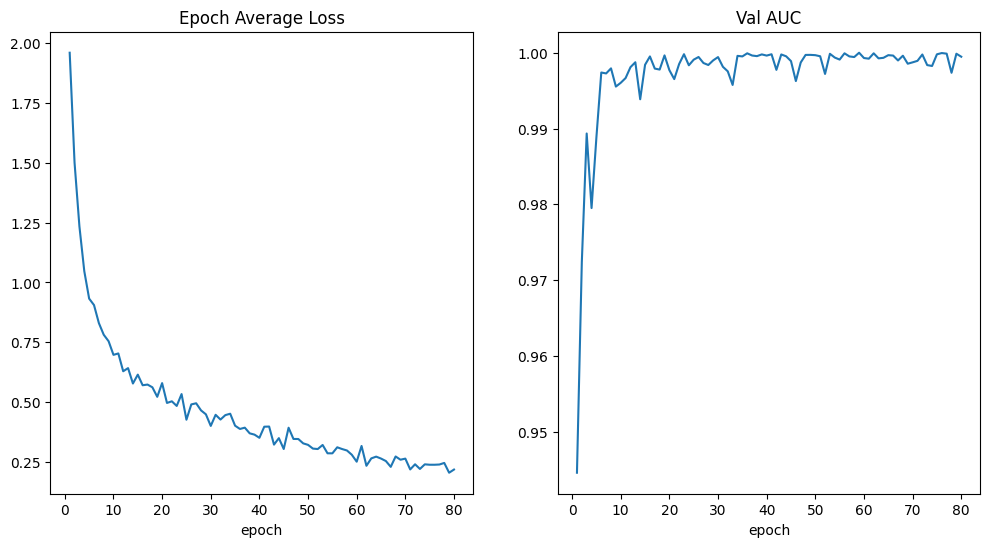

In [45]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [46]:
model.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [47]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.1579    0.0435    0.0682        69
           1     0.1709    0.3971    0.2389        68
           2     0.0877    0.2174    0.1250        69
           3     0.6818    0.2308    0.3448        65
           4     0.3478    0.2462    0.2883        65
           5     0.5600    0.4242    0.4828        66
           6     0.2500    0.0357    0.0625        28
           7     0.3750    0.2857    0.3243        21
           8     0.3939    0.6190    0.4815        21
           9     0.3065    0.2754    0.2901        69
          10     0.3103    0.1304    0.1837        69

    accuracy                         0.2492       610
   macro avg     0.3311    0.2641    0.2627       610
weighted avg     0.3249    0.2492    0.2524       610



In [48]:
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'coronal_random_unpretrained_seed{seed}.csv')

In [49]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 191.13 MB
Max VRAM used during training: 243.34 MB


## Training cycle for the sagittal part

## Pretrained

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(9, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 80
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "sagittal_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

----------
epoch 1/80
epoch 1 average loss: 2.1374


Epochs:   1%|▏         | 1/80 [00:09<12:57,  9.85s/it]

1
current epoch: 1 current AUC: 0.8534 current accuracy: 0.3913 best AUC: 1.0000 at epoch: 59
----------
epoch 2/80
epoch 2 average loss: 1.6273


Epochs:   2%|▎         | 2/80 [00:19<12:39,  9.73s/it]

1
current epoch: 2 current AUC: 0.9173 current accuracy: 0.4845 best AUC: 1.0000 at epoch: 59
----------
epoch 3/80
epoch 3 average loss: 1.4245


Epochs:   4%|▍         | 3/80 [00:29<12:34,  9.80s/it]

1
current epoch: 3 current AUC: 0.9394 current accuracy: 0.6460 best AUC: 1.0000 at epoch: 59
----------
epoch 4/80
epoch 4 average loss: 1.3150


Epochs:   5%|▌         | 4/80 [00:38<12:18,  9.72s/it]

1
current epoch: 4 current AUC: 0.9586 current accuracy: 0.5963 best AUC: 1.0000 at epoch: 59
----------
epoch 5/80
epoch 5 average loss: 1.2621


Epochs:   6%|▋         | 5/80 [00:48<12:07,  9.70s/it]

1
current epoch: 5 current AUC: 0.9580 current accuracy: 0.5901 best AUC: 1.0000 at epoch: 59
----------
epoch 6/80
epoch 6 average loss: 1.1761


Epochs:   8%|▊         | 6/80 [00:58<11:49,  9.59s/it]

1
current epoch: 6 current AUC: 0.9614 current accuracy: 0.6211 best AUC: 1.0000 at epoch: 59
----------
epoch 7/80
epoch 7 average loss: 1.1348


Epochs:   9%|▉         | 7/80 [01:07<11:28,  9.44s/it]

1
current epoch: 7 current AUC: 0.9593 current accuracy: 0.6398 best AUC: 1.0000 at epoch: 59
----------
epoch 8/80
epoch 8 average loss: 1.0549


Epochs:  10%|█         | 8/80 [01:16<11:12,  9.34s/it]

1
current epoch: 8 current AUC: 0.9658 current accuracy: 0.7019 best AUC: 1.0000 at epoch: 59
----------
epoch 9/80
epoch 9 average loss: 1.0481


Epochs:  11%|█▏        | 9/80 [01:25<10:58,  9.28s/it]

1
current epoch: 9 current AUC: 0.9724 current accuracy: 0.7578 best AUC: 1.0000 at epoch: 59
----------
epoch 10/80
epoch 10 average loss: 0.9960


Epochs:  12%|█▎        | 10/80 [01:34<10:48,  9.26s/it]

1
current epoch: 10 current AUC: 0.9737 current accuracy: 0.7329 best AUC: 1.0000 at epoch: 59
----------
epoch 11/80
epoch 11 average loss: 0.9715


Epochs:  14%|█▍        | 11/80 [01:43<10:38,  9.26s/it]

1
current epoch: 11 current AUC: 0.9824 current accuracy: 0.7702 best AUC: 1.0000 at epoch: 59
----------
epoch 12/80
epoch 12 average loss: 0.9468


Epochs:  15%|█▌        | 12/80 [01:53<10:28,  9.24s/it]

1
current epoch: 12 current AUC: 0.9700 current accuracy: 0.7205 best AUC: 1.0000 at epoch: 59
----------
epoch 13/80
epoch 13 average loss: 0.8742


Epochs:  16%|█▋        | 13/80 [02:02<10:16,  9.20s/it]

1
current epoch: 13 current AUC: 0.9751 current accuracy: 0.7143 best AUC: 1.0000 at epoch: 59
----------
epoch 14/80
epoch 14 average loss: 0.8393


Epochs:  18%|█▊        | 14/80 [02:11<10:06,  9.18s/it]

1
current epoch: 14 current AUC: 0.9865 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 59
----------
epoch 15/80
epoch 15 average loss: 0.8615


Epochs:  19%|█▉        | 15/80 [02:20<09:56,  9.18s/it]

1
current epoch: 15 current AUC: 0.9783 current accuracy: 0.7702 best AUC: 1.0000 at epoch: 59
----------
epoch 16/80
epoch 16 average loss: 0.7721


Epochs:  20%|██        | 16/80 [02:29<09:45,  9.15s/it]

1
current epoch: 16 current AUC: 0.9793 current accuracy: 0.7702 best AUC: 1.0000 at epoch: 59
----------
epoch 17/80
epoch 17 average loss: 0.8396


Epochs:  21%|██▏       | 17/80 [02:38<09:37,  9.16s/it]

1
current epoch: 17 current AUC: 0.9803 current accuracy: 0.7764 best AUC: 1.0000 at epoch: 59
----------
epoch 18/80
epoch 18 average loss: 0.7796


Epochs:  22%|██▎       | 18/80 [02:47<09:28,  9.17s/it]

1
current epoch: 18 current AUC: 0.9846 current accuracy: 0.8075 best AUC: 1.0000 at epoch: 59
----------
epoch 19/80
epoch 19 average loss: 0.7758


Epochs:  24%|██▍       | 19/80 [02:57<09:18,  9.16s/it]

1
current epoch: 19 current AUC: 0.9826 current accuracy: 0.8075 best AUC: 1.0000 at epoch: 59
----------
epoch 20/80
epoch 20 average loss: 0.7679


Epochs:  25%|██▌       | 20/80 [03:06<09:09,  9.16s/it]

1
current epoch: 20 current AUC: 0.9832 current accuracy: 0.7950 best AUC: 1.0000 at epoch: 59
----------
epoch 21/80
epoch 21 average loss: 0.7549


Epochs:  26%|██▋       | 21/80 [03:15<09:00,  9.15s/it]

1
current epoch: 21 current AUC: 0.9894 current accuracy: 0.8261 best AUC: 1.0000 at epoch: 59
----------
epoch 22/80
epoch 22 average loss: 0.6719


Epochs:  28%|██▊       | 22/80 [03:24<08:51,  9.16s/it]

1
current epoch: 22 current AUC: 0.9843 current accuracy: 0.8261 best AUC: 1.0000 at epoch: 59
----------
epoch 23/80
epoch 23 average loss: 0.7364


Epochs:  29%|██▉       | 23/80 [03:33<08:40,  9.13s/it]

1
current epoch: 23 current AUC: 0.9813 current accuracy: 0.8323 best AUC: 1.0000 at epoch: 59
----------
epoch 24/80
epoch 24 average loss: 0.6075


Epochs:  30%|███       | 24/80 [03:42<08:30,  9.12s/it]

1
current epoch: 24 current AUC: 0.9878 current accuracy: 0.8261 best AUC: 1.0000 at epoch: 59
----------
epoch 25/80
epoch 25 average loss: 0.6601


Epochs:  31%|███▏      | 25/80 [03:51<08:21,  9.12s/it]

1
current epoch: 25 current AUC: 0.9855 current accuracy: 0.8323 best AUC: 1.0000 at epoch: 59
----------
epoch 26/80
epoch 26 average loss: 0.6927


Epochs:  32%|███▎      | 26/80 [04:00<08:12,  9.12s/it]

1
current epoch: 26 current AUC: 0.9868 current accuracy: 0.7826 best AUC: 1.0000 at epoch: 59
----------
epoch 27/80
epoch 27 average loss: 0.7060


Epochs:  34%|███▍      | 27/80 [04:10<08:03,  9.13s/it]

1
current epoch: 27 current AUC: 0.9841 current accuracy: 0.7702 best AUC: 1.0000 at epoch: 59
----------
epoch 28/80
epoch 28 average loss: 0.7158


Epochs:  35%|███▌      | 28/80 [04:19<07:53,  9.11s/it]

1
current epoch: 28 current AUC: 0.9836 current accuracy: 0.7950 best AUC: 1.0000 at epoch: 59
----------
epoch 29/80
epoch 29 average loss: 0.6524


Epochs:  36%|███▋      | 29/80 [04:28<07:43,  9.09s/it]

1
current epoch: 29 current AUC: 0.9852 current accuracy: 0.7950 best AUC: 1.0000 at epoch: 59
----------
epoch 30/80
epoch 30 average loss: 0.5868


Epochs:  38%|███▊      | 30/80 [04:37<07:33,  9.07s/it]

1
current epoch: 30 current AUC: 0.9815 current accuracy: 0.7578 best AUC: 1.0000 at epoch: 59
----------
epoch 31/80
epoch 31 average loss: 0.6132


Epochs:  39%|███▉      | 31/80 [04:46<07:25,  9.08s/it]

1
current epoch: 31 current AUC: 0.9908 current accuracy: 0.8696 best AUC: 1.0000 at epoch: 59
----------
epoch 32/80
epoch 32 average loss: 0.5905


Epochs:  40%|████      | 32/80 [04:55<07:16,  9.08s/it]

1
current epoch: 32 current AUC: 0.9861 current accuracy: 0.8137 best AUC: 1.0000 at epoch: 59
----------
epoch 33/80
epoch 33 average loss: 0.6099


Epochs:  41%|████▏     | 33/80 [05:04<07:08,  9.11s/it]

1
current epoch: 33 current AUC: 0.9824 current accuracy: 0.8012 best AUC: 1.0000 at epoch: 59
----------
epoch 34/80
epoch 34 average loss: 0.6131


Epochs:  42%|████▎     | 34/80 [05:13<07:00,  9.14s/it]

1
current epoch: 34 current AUC: 0.9811 current accuracy: 0.8199 best AUC: 1.0000 at epoch: 59
----------
epoch 35/80
epoch 35 average loss: 0.5629


Epochs:  44%|████▍     | 35/80 [05:22<06:51,  9.13s/it]

1
current epoch: 35 current AUC: 0.9800 current accuracy: 0.8199 best AUC: 1.0000 at epoch: 59
----------
epoch 36/80
epoch 36 average loss: 0.5912


Epochs:  45%|████▌     | 36/80 [05:32<06:43,  9.17s/it]

1
current epoch: 36 current AUC: 0.9804 current accuracy: 0.7578 best AUC: 1.0000 at epoch: 59
----------
epoch 37/80
epoch 37 average loss: 0.5654


Epochs:  46%|████▋     | 37/80 [05:41<06:32,  9.13s/it]

1
current epoch: 37 current AUC: 0.9886 current accuracy: 0.8137 best AUC: 1.0000 at epoch: 59
----------
epoch 38/80
epoch 38 average loss: 0.5292


Epochs:  48%|████▊     | 38/80 [05:50<06:23,  9.13s/it]

1
current epoch: 38 current AUC: 0.9922 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 59
----------
epoch 39/80
epoch 39 average loss: 0.5458


Epochs:  49%|████▉     | 39/80 [05:59<06:14,  9.14s/it]

1
current epoch: 39 current AUC: 0.9879 current accuracy: 0.8323 best AUC: 1.0000 at epoch: 59
----------
epoch 40/80
epoch 40 average loss: 0.5358


Epochs:  50%|█████     | 40/80 [06:08<06:06,  9.15s/it]

1
current epoch: 40 current AUC: 0.9922 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 59
----------
epoch 41/80
epoch 41 average loss: 0.5527


Epochs:  51%|█████▏    | 41/80 [06:18<06:00,  9.23s/it]

1
current epoch: 41 current AUC: 0.9881 current accuracy: 0.8385 best AUC: 1.0000 at epoch: 59
----------
epoch 42/80
epoch 42 average loss: 0.5417


Epochs:  52%|█████▎    | 42/80 [06:28<05:59,  9.45s/it]

1
current epoch: 42 current AUC: 0.9935 current accuracy: 0.8758 best AUC: 1.0000 at epoch: 59
----------
epoch 43/80
epoch 43 average loss: 0.5017


Epochs:  54%|█████▍    | 43/80 [06:37<05:54,  9.58s/it]

1
current epoch: 43 current AUC: 0.9802 current accuracy: 0.7578 best AUC: 1.0000 at epoch: 59
----------
epoch 44/80
epoch 44 average loss: 0.5350


Epochs:  55%|█████▌    | 44/80 [06:47<05:46,  9.63s/it]

1
current epoch: 44 current AUC: 0.9859 current accuracy: 0.8075 best AUC: 1.0000 at epoch: 59
----------
epoch 45/80
epoch 45 average loss: 0.4764


Epochs:  56%|█████▋    | 45/80 [06:57<05:36,  9.62s/it]

1
current epoch: 45 current AUC: 0.9895 current accuracy: 0.8385 best AUC: 1.0000 at epoch: 59
----------
epoch 46/80
epoch 46 average loss: 0.5092


Epochs:  57%|█████▊    | 46/80 [07:07<05:32,  9.77s/it]

1
current epoch: 46 current AUC: 0.9830 current accuracy: 0.7826 best AUC: 1.0000 at epoch: 59
----------
epoch 47/80
epoch 47 average loss: 0.5032


Epochs:  59%|█████▉    | 47/80 [07:17<05:27,  9.91s/it]

1
current epoch: 47 current AUC: 0.9774 current accuracy: 0.7516 best AUC: 1.0000 at epoch: 59
----------
epoch 48/80
epoch 48 average loss: 0.4971


Epochs:  60%|██████    | 48/80 [07:27<05:20, 10.02s/it]

1
current epoch: 48 current AUC: 0.9909 current accuracy: 0.8137 best AUC: 1.0000 at epoch: 59
----------
epoch 49/80
epoch 49 average loss: 0.5341


Epochs:  61%|██████▏   | 49/80 [07:38<05:11, 10.06s/it]

1
current epoch: 49 current AUC: 0.9911 current accuracy: 0.8571 best AUC: 1.0000 at epoch: 59
----------
epoch 50/80
epoch 50 average loss: 0.4753


Epochs:  62%|██████▎   | 50/80 [07:48<05:03, 10.13s/it]

1
current epoch: 50 current AUC: 0.9844 current accuracy: 0.8075 best AUC: 1.0000 at epoch: 59
----------
epoch 51/80
epoch 51 average loss: 0.5014


Epochs:  64%|██████▍   | 51/80 [07:58<04:55, 10.18s/it]

1
current epoch: 51 current AUC: 0.9853 current accuracy: 0.7888 best AUC: 1.0000 at epoch: 59
----------
epoch 52/80
epoch 52 average loss: 0.4460


Epochs:  65%|██████▌   | 52/80 [08:08<04:45, 10.19s/it]

1
current epoch: 52 current AUC: 0.9915 current accuracy: 0.8634 best AUC: 1.0000 at epoch: 59
----------
epoch 53/80
epoch 53 average loss: 0.4718


Epochs:  66%|██████▋   | 53/80 [08:19<04:35, 10.21s/it]

1
current epoch: 53 current AUC: 0.9928 current accuracy: 0.8447 best AUC: 1.0000 at epoch: 59
----------
epoch 54/80
epoch 54 average loss: 0.4635


Epochs:  68%|██████▊   | 54/80 [08:29<04:24, 10.19s/it]

1
current epoch: 54 current AUC: 0.9838 current accuracy: 0.8137 best AUC: 1.0000 at epoch: 59
----------
epoch 55/80
epoch 55 average loss: 0.4888


Epochs:  69%|██████▉   | 55/80 [08:38<04:06,  9.85s/it]

1
current epoch: 55 current AUC: 0.9835 current accuracy: 0.8012 best AUC: 1.0000 at epoch: 59
----------
epoch 56/80
epoch 56 average loss: 0.4327


Epochs:  70%|███████   | 56/80 [08:47<03:53,  9.74s/it]

1
current epoch: 56 current AUC: 0.9865 current accuracy: 0.8137 best AUC: 1.0000 at epoch: 59
----------
epoch 57/80
epoch 57 average loss: 0.4542


Epochs:  71%|███████▏  | 57/80 [08:57<03:40,  9.59s/it]

1
current epoch: 57 current AUC: 0.9857 current accuracy: 0.7826 best AUC: 1.0000 at epoch: 59
----------
epoch 58/80
epoch 58 average loss: 0.4301


Epochs:  72%|███████▎  | 58/80 [09:06<03:30,  9.58s/it]

1
current epoch: 58 current AUC: 0.9852 current accuracy: 0.8385 best AUC: 1.0000 at epoch: 59
----------
epoch 59/80
epoch 59 average loss: 0.4690


Epochs:  74%|███████▍  | 59/80 [09:15<03:19,  9.48s/it]

1
current epoch: 59 current AUC: 0.9886 current accuracy: 0.8447 best AUC: 1.0000 at epoch: 59
----------
epoch 60/80
epoch 60 average loss: 0.4384


Epochs:  75%|███████▌  | 60/80 [09:25<03:10,  9.51s/it]

1
current epoch: 60 current AUC: 0.9799 current accuracy: 0.7702 best AUC: 1.0000 at epoch: 59
----------
epoch 61/80
epoch 61 average loss: 0.4990


Epochs:  76%|███████▋  | 61/80 [09:34<02:58,  9.41s/it]

1
current epoch: 61 current AUC: 0.9883 current accuracy: 0.8634 best AUC: 1.0000 at epoch: 59
----------
epoch 62/80
epoch 62 average loss: 0.4229


Epochs:  78%|███████▊  | 62/80 [09:44<02:49,  9.44s/it]

1
current epoch: 62 current AUC: 0.9871 current accuracy: 0.8385 best AUC: 1.0000 at epoch: 59
----------
epoch 63/80
epoch 63 average loss: 0.3917


Epochs:  79%|███████▉  | 63/80 [09:53<02:39,  9.40s/it]

1
current epoch: 63 current AUC: 0.9890 current accuracy: 0.8385 best AUC: 1.0000 at epoch: 59
----------
epoch 64/80
epoch 64 average loss: 0.4721


Epochs:  80%|████████  | 64/80 [10:02<02:30,  9.43s/it]

1
current epoch: 64 current AUC: 0.9805 current accuracy: 0.7888 best AUC: 1.0000 at epoch: 59
----------
epoch 65/80
epoch 65 average loss: 0.4467


Epochs:  81%|████████▏ | 65/80 [10:12<02:22,  9.47s/it]

1
current epoch: 65 current AUC: 0.9861 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 59
----------
epoch 66/80
epoch 66 average loss: 0.4029


Epochs:  82%|████████▎ | 66/80 [10:21<02:12,  9.45s/it]

1
current epoch: 66 current AUC: 0.9828 current accuracy: 0.8385 best AUC: 1.0000 at epoch: 59
----------
epoch 67/80
epoch 67 average loss: 0.3832


Epochs:  84%|████████▍ | 67/80 [10:31<02:03,  9.47s/it]

1
current epoch: 67 current AUC: 0.9869 current accuracy: 0.8199 best AUC: 1.0000 at epoch: 59
----------
epoch 68/80
epoch 68 average loss: 0.3944


Epochs:  85%|████████▌ | 68/80 [10:40<01:52,  9.41s/it]

1
current epoch: 68 current AUC: 0.9908 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 59
----------
epoch 69/80
epoch 69 average loss: 0.3919


Epochs:  86%|████████▋ | 69/80 [10:49<01:43,  9.37s/it]

1
current epoch: 69 current AUC: 0.9900 current accuracy: 0.8696 best AUC: 1.0000 at epoch: 59
----------
epoch 70/80
epoch 70 average loss: 0.4101


Epochs:  88%|████████▊ | 70/80 [10:59<01:33,  9.31s/it]

1
current epoch: 70 current AUC: 0.9881 current accuracy: 0.8447 best AUC: 1.0000 at epoch: 59
----------
epoch 71/80
epoch 71 average loss: 0.3526


Epochs:  89%|████████▉ | 71/80 [11:08<01:23,  9.33s/it]

1
current epoch: 71 current AUC: 0.9887 current accuracy: 0.8447 best AUC: 1.0000 at epoch: 59
----------
epoch 72/80
epoch 72 average loss: 0.4037


Epochs:  90%|█████████ | 72/80 [11:17<01:14,  9.32s/it]

1
current epoch: 72 current AUC: 0.9818 current accuracy: 0.7764 best AUC: 1.0000 at epoch: 59
----------
epoch 73/80
epoch 73 average loss: 0.3583


Epochs:  91%|█████████▏| 73/80 [11:27<01:05,  9.40s/it]

1
current epoch: 73 current AUC: 0.9858 current accuracy: 0.8199 best AUC: 1.0000 at epoch: 59
----------
epoch 74/80
epoch 74 average loss: 0.3984


Epochs:  92%|█████████▎| 74/80 [11:36<00:56,  9.41s/it]

1
current epoch: 74 current AUC: 0.9931 current accuracy: 0.8509 best AUC: 1.0000 at epoch: 59
----------
epoch 75/80
epoch 75 average loss: 0.3857


Epochs:  94%|█████████▍| 75/80 [11:46<00:47,  9.43s/it]

1
current epoch: 75 current AUC: 0.9931 current accuracy: 0.8696 best AUC: 1.0000 at epoch: 59
----------
epoch 76/80
epoch 76 average loss: 0.3673


Epochs:  95%|█████████▌| 76/80 [11:55<00:37,  9.48s/it]

1
current epoch: 76 current AUC: 0.9899 current accuracy: 0.8696 best AUC: 1.0000 at epoch: 59
----------
epoch 77/80
epoch 77 average loss: 0.3394


Epochs:  96%|█████████▋| 77/80 [12:05<00:28,  9.47s/it]

1
current epoch: 77 current AUC: 0.9834 current accuracy: 0.8385 best AUC: 1.0000 at epoch: 59
----------
epoch 78/80
epoch 78 average loss: 0.3440


Epochs:  98%|█████████▊| 78/80 [12:14<00:18,  9.40s/it]

1
current epoch: 78 current AUC: 0.9809 current accuracy: 0.8012 best AUC: 1.0000 at epoch: 59
----------
epoch 79/80
epoch 79 average loss: 0.3314


Epochs:  99%|█████████▉| 79/80 [12:24<00:09,  9.41s/it]

1
current epoch: 79 current AUC: 0.9843 current accuracy: 0.8137 best AUC: 1.0000 at epoch: 59
----------
epoch 80/80
epoch 80 average loss: 0.3859


Epochs: 100%|██████████| 80/80 [12:33<00:00,  9.42s/it]

1
current epoch: 80 current AUC: 0.9902 current accuracy: 0.8571 best AUC: 1.0000 at epoch: 59
train completed, best_metric: 1.0000 at epoch: 59


In [52]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 1532.31 seconds
CPU time used: 18335.93 seconds
Memory used: 450.62 MB
GPU Memory Used: 192.00 MB
Max GPU Memory Used: 235.60 MB


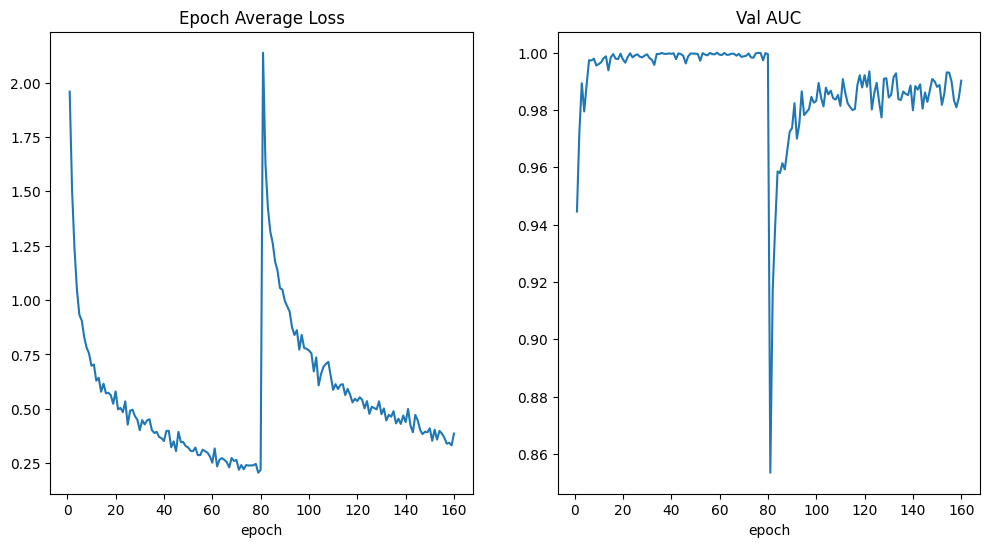

In [53]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [54]:
model.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_sagittal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [55]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9437    0.9710    0.9571        69
           1     0.6140    0.5147    0.5600        68
           2     0.6275    0.4638    0.5333        69
           3     0.5714    0.5538    0.5625        65
           4     0.5190    0.6308    0.5694        65
           5     0.7619    0.9697    0.8533        66
           6     0.9600    0.8571    0.9057        28
           7     0.7826    0.8571    0.8182        21
           8     0.9375    0.7143    0.8108        21
           9     0.8354    0.9565    0.8919        69
          10     0.9677    0.8696    0.9160        69

    accuracy                         0.7508       610
   macro avg     0.7746    0.7599    0.7617       610
weighted avg     0.7520    0.7508    0.7461       610



In [56]:
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'sagittal_random_pretrained_seed{seed}.csv')

In [57]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 191.99 MB
Max VRAM used during training: 235.65 MB


## Unpretrained

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 80
val_interval = 1
auc_metric = ROCAUCMetric()

In [59]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "sagittal_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

----------
epoch 1/80
epoch 1 average loss: 1.9701
1


Epochs:   1%|▏         | 1/80 [00:09<12:43,  9.66s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9033 current accuracy: 0.4286 best AUC: 0.9033 at epoch: 1
----------
epoch 2/80
epoch 2 average loss: 1.6022
1


Epochs:   2%|▎         | 2/80 [00:19<12:40,  9.75s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9300 current accuracy: 0.5093 best AUC: 0.9300 at epoch: 2
----------
epoch 3/80
epoch 3 average loss: 1.3904
1


Epochs:   4%|▍         | 3/80 [00:28<12:22,  9.65s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9515 current accuracy: 0.5839 best AUC: 0.9515 at epoch: 3
----------
epoch 4/80
epoch 4 average loss: 1.2946
1


Epochs:   5%|▌         | 4/80 [00:38<12:22,  9.78s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9633 current accuracy: 0.6460 best AUC: 0.9633 at epoch: 4
----------
epoch 5/80
epoch 5 average loss: 1.2183


Epochs:   6%|▋         | 5/80 [00:48<11:58,  9.58s/it]

1
current epoch: 5 current AUC: 0.9591 current accuracy: 0.6025 best AUC: 0.9633 at epoch: 4
----------
epoch 6/80
epoch 6 average loss: 1.1334


Epochs:   8%|▊         | 6/80 [00:57<11:45,  9.53s/it]

1
current epoch: 6 current AUC: 0.9592 current accuracy: 0.5590 best AUC: 0.9633 at epoch: 4
----------
epoch 7/80
epoch 7 average loss: 1.1438
1


Epochs:   9%|▉         | 7/80 [01:07<11:34,  9.52s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9677 current accuracy: 0.6025 best AUC: 0.9677 at epoch: 7
----------
epoch 8/80
epoch 8 average loss: 1.0484
1


Epochs:  10%|█         | 8/80 [01:16<11:25,  9.52s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9732 current accuracy: 0.6335 best AUC: 0.9732 at epoch: 8
----------
epoch 9/80
epoch 9 average loss: 1.0450
1


Epochs:  11%|█▏        | 9/80 [01:26<11:14,  9.50s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9742 current accuracy: 0.6646 best AUC: 0.9742 at epoch: 9
----------
epoch 10/80
epoch 10 average loss: 0.9804
1


Epochs:  12%|█▎        | 10/80 [01:35<11:01,  9.45s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9812 current accuracy: 0.7391 best AUC: 0.9812 at epoch: 10
----------
epoch 11/80
epoch 11 average loss: 0.9167


Epochs:  14%|█▍        | 11/80 [01:44<10:40,  9.28s/it]

1
current epoch: 11 current AUC: 0.9748 current accuracy: 0.6894 best AUC: 0.9812 at epoch: 10
----------
epoch 12/80
epoch 12 average loss: 0.8705
1


Epochs:  15%|█▌        | 12/80 [01:53<10:35,  9.34s/it]

saved new best metric model
current epoch: 12 current AUC: 0.9823 current accuracy: 0.7516 best AUC: 0.9823 at epoch: 12
----------
epoch 13/80
epoch 13 average loss: 0.8686
1


Epochs:  16%|█▋        | 13/80 [02:03<10:26,  9.34s/it]

saved new best metric model
current epoch: 13 current AUC: 0.9908 current accuracy: 0.8199 best AUC: 0.9908 at epoch: 13
----------
epoch 14/80
epoch 14 average loss: 0.8749


Epochs:  18%|█▊        | 14/80 [02:12<10:08,  9.22s/it]

1
current epoch: 14 current AUC: 0.9792 current accuracy: 0.7329 best AUC: 0.9908 at epoch: 13
----------
epoch 15/80
epoch 15 average loss: 0.8718


Epochs:  19%|█▉        | 15/80 [02:21<09:57,  9.19s/it]

1
current epoch: 15 current AUC: 0.9832 current accuracy: 0.7205 best AUC: 0.9908 at epoch: 13
----------
epoch 16/80
epoch 16 average loss: 0.8059


Epochs:  20%|██        | 16/80 [02:30<09:46,  9.16s/it]

1
current epoch: 16 current AUC: 0.9895 current accuracy: 0.7205 best AUC: 0.9908 at epoch: 13
----------
epoch 17/80
epoch 17 average loss: 0.8379


Epochs:  21%|██▏       | 17/80 [02:39<09:34,  9.11s/it]

1
current epoch: 17 current AUC: 0.9849 current accuracy: 0.7826 best AUC: 0.9908 at epoch: 13
----------
epoch 18/80
epoch 18 average loss: 0.7732


Epochs:  22%|██▎       | 18/80 [02:48<09:23,  9.09s/it]

1
current epoch: 18 current AUC: 0.9813 current accuracy: 0.8075 best AUC: 0.9908 at epoch: 13
----------
epoch 19/80
epoch 19 average loss: 0.8217


Epochs:  24%|██▍       | 19/80 [02:57<09:12,  9.05s/it]

1
current epoch: 19 current AUC: 0.9805 current accuracy: 0.7578 best AUC: 0.9908 at epoch: 13
----------
epoch 20/80
epoch 20 average loss: 0.7877


Epochs:  25%|██▌       | 20/80 [03:06<09:03,  9.05s/it]

1
current epoch: 20 current AUC: 0.9811 current accuracy: 0.7702 best AUC: 0.9908 at epoch: 13
----------
epoch 21/80
epoch 21 average loss: 0.7865


Epochs:  26%|██▋       | 21/80 [03:15<08:54,  9.05s/it]

1
current epoch: 21 current AUC: 0.9796 current accuracy: 0.6957 best AUC: 0.9908 at epoch: 13
----------
epoch 22/80
epoch 22 average loss: 0.7889


Epochs:  28%|██▊       | 22/80 [03:24<08:45,  9.06s/it]

1
current epoch: 22 current AUC: 0.9828 current accuracy: 0.7391 best AUC: 0.9908 at epoch: 13
----------
epoch 23/80
epoch 23 average loss: 0.6961


Epochs:  29%|██▉       | 23/80 [03:33<08:34,  9.02s/it]

1
current epoch: 23 current AUC: 0.9830 current accuracy: 0.8012 best AUC: 0.9908 at epoch: 13
----------
epoch 24/80
epoch 24 average loss: 0.7081


Epochs:  30%|███       | 24/80 [03:42<08:26,  9.04s/it]

1
current epoch: 24 current AUC: 0.9870 current accuracy: 0.8012 best AUC: 0.9908 at epoch: 13
----------
epoch 25/80
epoch 25 average loss: 0.7390


Epochs:  31%|███▏      | 25/80 [03:51<08:16,  9.03s/it]

1
current epoch: 25 current AUC: 0.9836 current accuracy: 0.7453 best AUC: 0.9908 at epoch: 13
----------
epoch 26/80
epoch 26 average loss: 0.7657


Epochs:  32%|███▎      | 26/80 [04:00<08:07,  9.03s/it]

1
current epoch: 26 current AUC: 0.9802 current accuracy: 0.7391 best AUC: 0.9908 at epoch: 13
----------
epoch 27/80
epoch 27 average loss: 0.6839


Epochs:  34%|███▍      | 27/80 [04:09<07:58,  9.02s/it]

1
current epoch: 27 current AUC: 0.9852 current accuracy: 0.7578 best AUC: 0.9908 at epoch: 13
----------
epoch 28/80
epoch 28 average loss: 0.6462


Epochs:  35%|███▌      | 28/80 [04:18<07:52,  9.09s/it]

1
current epoch: 28 current AUC: 0.9843 current accuracy: 0.7578 best AUC: 0.9908 at epoch: 13
----------
epoch 29/80
epoch 29 average loss: 0.7359


Epochs:  36%|███▋      | 29/80 [04:27<07:42,  9.06s/it]

1
current epoch: 29 current AUC: 0.9881 current accuracy: 0.8137 best AUC: 0.9908 at epoch: 13
----------
epoch 30/80
epoch 30 average loss: 0.6710


Epochs:  38%|███▊      | 30/80 [04:36<07:34,  9.10s/it]

1
current epoch: 30 current AUC: 0.9856 current accuracy: 0.7826 best AUC: 0.9908 at epoch: 13
----------
epoch 31/80
epoch 31 average loss: 0.6589


Epochs:  39%|███▉      | 31/80 [04:46<07:24,  9.08s/it]

1
current epoch: 31 current AUC: 0.9821 current accuracy: 0.7453 best AUC: 0.9908 at epoch: 13
----------
epoch 32/80
epoch 32 average loss: 0.6404


Epochs:  40%|████      | 32/80 [04:55<07:16,  9.09s/it]

1
current epoch: 32 current AUC: 0.9813 current accuracy: 0.7640 best AUC: 0.9908 at epoch: 13
----------
epoch 33/80
epoch 33 average loss: 0.6265


Epochs:  41%|████▏     | 33/80 [05:04<07:05,  9.05s/it]

1
current epoch: 33 current AUC: 0.9816 current accuracy: 0.7764 best AUC: 0.9908 at epoch: 13
----------
epoch 34/80
epoch 34 average loss: 0.6630


Epochs:  42%|████▎     | 34/80 [05:13<06:58,  9.10s/it]

1
current epoch: 34 current AUC: 0.9889 current accuracy: 0.8199 best AUC: 0.9908 at epoch: 13
----------
epoch 35/80
epoch 35 average loss: 0.6158


Epochs:  44%|████▍     | 35/80 [05:22<06:47,  9.07s/it]

1
current epoch: 35 current AUC: 0.9817 current accuracy: 0.7764 best AUC: 0.9908 at epoch: 13
----------
epoch 36/80
epoch 36 average loss: 0.5942


Epochs:  45%|████▌     | 36/80 [05:31<06:39,  9.07s/it]

1
current epoch: 36 current AUC: 0.9844 current accuracy: 0.7764 best AUC: 0.9908 at epoch: 13
----------
epoch 37/80
epoch 37 average loss: 0.6448


Epochs:  46%|████▋     | 37/80 [05:40<06:28,  9.04s/it]

1
current epoch: 37 current AUC: 0.9870 current accuracy: 0.8012 best AUC: 0.9908 at epoch: 13
----------
epoch 38/80
epoch 38 average loss: 0.5827


Epochs:  48%|████▊     | 38/80 [05:49<06:21,  9.09s/it]

1
current epoch: 38 current AUC: 0.9866 current accuracy: 0.8075 best AUC: 0.9908 at epoch: 13
----------
epoch 39/80
epoch 39 average loss: 0.6473


Epochs:  49%|████▉     | 39/80 [05:58<06:11,  9.05s/it]

1
current epoch: 39 current AUC: 0.9850 current accuracy: 0.8075 best AUC: 0.9908 at epoch: 13
----------
epoch 40/80
epoch 40 average loss: 0.5850


Epochs:  50%|█████     | 40/80 [06:07<06:00,  9.02s/it]

1
current epoch: 40 current AUC: 0.9830 current accuracy: 0.7826 best AUC: 0.9908 at epoch: 13
----------
epoch 41/80
epoch 41 average loss: 0.5807


Epochs:  51%|█████▏    | 41/80 [06:16<05:52,  9.03s/it]

1
current epoch: 41 current AUC: 0.9816 current accuracy: 0.7888 best AUC: 0.9908 at epoch: 13
----------
epoch 42/80
epoch 42 average loss: 0.5743


Epochs:  52%|█████▎    | 42/80 [06:25<05:43,  9.05s/it]

1
current epoch: 42 current AUC: 0.9840 current accuracy: 0.7826 best AUC: 0.9908 at epoch: 13
----------
epoch 43/80
epoch 43 average loss: 0.5547
1


Epochs:  54%|█████▍    | 43/80 [06:34<05:38,  9.14s/it]

saved new best metric model
current epoch: 43 current AUC: 0.9919 current accuracy: 0.8199 best AUC: 0.9919 at epoch: 43
----------
epoch 44/80
epoch 44 average loss: 0.5455


Epochs:  55%|█████▌    | 44/80 [06:44<05:28,  9.12s/it]

1
current epoch: 44 current AUC: 0.9802 current accuracy: 0.7143 best AUC: 0.9919 at epoch: 43
----------
epoch 45/80
epoch 45 average loss: 0.5650


Epochs:  56%|█████▋    | 45/80 [06:53<05:17,  9.08s/it]

1
current epoch: 45 current AUC: 0.9804 current accuracy: 0.7516 best AUC: 0.9919 at epoch: 43
----------
epoch 46/80
epoch 46 average loss: 0.5597


Epochs:  57%|█████▊    | 46/80 [07:02<05:09,  9.11s/it]

1
current epoch: 46 current AUC: 0.9823 current accuracy: 0.7391 best AUC: 0.9919 at epoch: 43
----------
epoch 47/80
epoch 47 average loss: 0.5631


Epochs:  59%|█████▉    | 47/80 [07:11<04:59,  9.07s/it]

1
current epoch: 47 current AUC: 0.9900 current accuracy: 0.8012 best AUC: 0.9919 at epoch: 43
----------
epoch 48/80
epoch 48 average loss: 0.5774


Epochs:  60%|██████    | 48/80 [07:20<04:49,  9.04s/it]

1
current epoch: 48 current AUC: 0.9809 current accuracy: 0.7329 best AUC: 0.9919 at epoch: 43
----------
epoch 49/80
epoch 49 average loss: 0.5461


Epochs:  61%|██████▏   | 49/80 [07:29<04:39,  9.01s/it]

1
current epoch: 49 current AUC: 0.9808 current accuracy: 0.7453 best AUC: 0.9919 at epoch: 43
----------
epoch 50/80
epoch 50 average loss: 0.5433


Epochs:  62%|██████▎   | 50/80 [07:38<04:30,  9.03s/it]

1
current epoch: 50 current AUC: 0.9870 current accuracy: 0.8199 best AUC: 0.9919 at epoch: 43
----------
epoch 51/80
epoch 51 average loss: 0.5062


Epochs:  64%|██████▍   | 51/80 [07:47<04:21,  9.01s/it]

1
current epoch: 51 current AUC: 0.9857 current accuracy: 0.7888 best AUC: 0.9919 at epoch: 43
----------
epoch 52/80
epoch 52 average loss: 0.4836


Epochs:  65%|██████▌   | 52/80 [07:56<04:13,  9.06s/it]

1
current epoch: 52 current AUC: 0.9882 current accuracy: 0.8012 best AUC: 0.9919 at epoch: 43
----------
epoch 53/80
epoch 53 average loss: 0.5282


Epochs:  66%|██████▋   | 53/80 [08:05<04:05,  9.08s/it]

1
current epoch: 53 current AUC: 0.9887 current accuracy: 0.7764 best AUC: 0.9919 at epoch: 43
----------
epoch 54/80
epoch 54 average loss: 0.5046


Epochs:  68%|██████▊   | 54/80 [08:14<03:56,  9.11s/it]

1
current epoch: 54 current AUC: 0.9867 current accuracy: 0.8075 best AUC: 0.9919 at epoch: 43
----------
epoch 55/80
epoch 55 average loss: 0.4968


Epochs:  69%|██████▉   | 55/80 [08:23<03:47,  9.09s/it]

1
current epoch: 55 current AUC: 0.9899 current accuracy: 0.8447 best AUC: 0.9919 at epoch: 43
----------
epoch 56/80
epoch 56 average loss: 0.4308


Epochs:  70%|███████   | 56/80 [08:32<03:38,  9.10s/it]

1
current epoch: 56 current AUC: 0.9863 current accuracy: 0.8385 best AUC: 0.9919 at epoch: 43
----------
epoch 57/80
epoch 57 average loss: 0.4972


Epochs:  71%|███████▏  | 57/80 [08:41<03:28,  9.06s/it]

1
current epoch: 57 current AUC: 0.9830 current accuracy: 0.7826 best AUC: 0.9919 at epoch: 43
----------
epoch 58/80
epoch 58 average loss: 0.5049


Epochs:  72%|███████▎  | 58/80 [08:51<03:20,  9.13s/it]

1
current epoch: 58 current AUC: 0.9906 current accuracy: 0.8571 best AUC: 0.9919 at epoch: 43
----------
epoch 59/80
epoch 59 average loss: 0.4476


Epochs:  74%|███████▍  | 59/80 [09:00<03:10,  9.08s/it]

1
current epoch: 59 current AUC: 0.9879 current accuracy: 0.8199 best AUC: 0.9919 at epoch: 43
----------
epoch 60/80
epoch 60 average loss: 0.4711


Epochs:  75%|███████▌  | 60/80 [09:09<03:01,  9.09s/it]

1
current epoch: 60 current AUC: 0.9896 current accuracy: 0.8385 best AUC: 0.9919 at epoch: 43
----------
epoch 61/80
epoch 61 average loss: 0.5123


Epochs:  76%|███████▋  | 61/80 [09:18<02:52,  9.07s/it]

1
current epoch: 61 current AUC: 0.9883 current accuracy: 0.8075 best AUC: 0.9919 at epoch: 43
----------
epoch 62/80
epoch 62 average loss: 0.4869


Epochs:  78%|███████▊  | 62/80 [09:27<02:44,  9.12s/it]

1
current epoch: 62 current AUC: 0.9826 current accuracy: 0.7578 best AUC: 0.9919 at epoch: 43
----------
epoch 63/80
epoch 63 average loss: 0.4731


Epochs:  79%|███████▉  | 63/80 [09:36<02:33,  9.06s/it]

1
current epoch: 63 current AUC: 0.9859 current accuracy: 0.7702 best AUC: 0.9919 at epoch: 43
----------
epoch 64/80
epoch 64 average loss: 0.4741
1


Epochs:  80%|████████  | 64/80 [09:45<02:26,  9.15s/it]

saved new best metric model
current epoch: 64 current AUC: 0.9957 current accuracy: 0.8882 best AUC: 0.9957 at epoch: 64
----------
epoch 65/80
epoch 65 average loss: 0.4662


Epochs:  81%|████████▏ | 65/80 [09:54<02:16,  9.11s/it]

1
current epoch: 65 current AUC: 0.9830 current accuracy: 0.7640 best AUC: 0.9957 at epoch: 64
----------
epoch 66/80
epoch 66 average loss: 0.4191


Epochs:  82%|████████▎ | 66/80 [10:03<02:06,  9.07s/it]

1
current epoch: 66 current AUC: 0.9885 current accuracy: 0.8075 best AUC: 0.9957 at epoch: 64
----------
epoch 67/80
epoch 67 average loss: 0.4458


Epochs:  84%|████████▍ | 67/80 [10:12<01:57,  9.06s/it]

1
current epoch: 67 current AUC: 0.9897 current accuracy: 0.8385 best AUC: 0.9957 at epoch: 64
----------
epoch 68/80
epoch 68 average loss: 0.4465


Epochs:  85%|████████▌ | 68/80 [10:21<01:48,  9.07s/it]

1
current epoch: 68 current AUC: 0.9872 current accuracy: 0.8261 best AUC: 0.9957 at epoch: 64
----------
epoch 69/80
epoch 69 average loss: 0.4498


Epochs:  86%|████████▋ | 69/80 [10:30<01:40,  9.09s/it]

1
current epoch: 69 current AUC: 0.9829 current accuracy: 0.8012 best AUC: 0.9957 at epoch: 64
----------
epoch 70/80
epoch 70 average loss: 0.4758


Epochs:  88%|████████▊ | 70/80 [10:39<01:30,  9.02s/it]

1
current epoch: 70 current AUC: 0.9836 current accuracy: 0.7640 best AUC: 0.9957 at epoch: 64
----------
epoch 71/80
epoch 71 average loss: 0.4426


Epochs:  89%|████████▉ | 71/80 [10:48<01:20,  8.96s/it]

1
current epoch: 71 current AUC: 0.9877 current accuracy: 0.8447 best AUC: 0.9957 at epoch: 64
----------
epoch 72/80
epoch 72 average loss: 0.4474


Epochs:  90%|█████████ | 72/80 [10:57<01:11,  8.96s/it]

1
current epoch: 72 current AUC: 0.9930 current accuracy: 0.8634 best AUC: 0.9957 at epoch: 64
----------
epoch 73/80
epoch 73 average loss: 0.4342


Epochs:  91%|█████████▏| 73/80 [11:06<01:02,  8.95s/it]

1
current epoch: 73 current AUC: 0.9832 current accuracy: 0.7764 best AUC: 0.9957 at epoch: 64
----------
epoch 74/80
epoch 74 average loss: 0.4419


Epochs:  92%|█████████▎| 74/80 [11:15<00:53,  8.89s/it]

1
current epoch: 74 current AUC: 0.9836 current accuracy: 0.8261 best AUC: 0.9957 at epoch: 64
----------
epoch 75/80
epoch 75 average loss: 0.4301


Epochs:  94%|█████████▍| 75/80 [11:24<00:44,  8.87s/it]

1
current epoch: 75 current AUC: 0.9919 current accuracy: 0.8323 best AUC: 0.9957 at epoch: 64
----------
epoch 76/80
epoch 76 average loss: 0.4286


Epochs:  95%|█████████▌| 76/80 [11:32<00:35,  8.86s/it]

1
current epoch: 76 current AUC: 0.9895 current accuracy: 0.8571 best AUC: 0.9957 at epoch: 64
----------
epoch 77/80
epoch 77 average loss: 0.4736


Epochs:  96%|█████████▋| 77/80 [11:41<00:26,  8.86s/it]

1
current epoch: 77 current AUC: 0.9932 current accuracy: 0.8758 best AUC: 0.9957 at epoch: 64
----------
epoch 78/80
epoch 78 average loss: 0.4216


Epochs:  98%|█████████▊| 78/80 [11:50<00:17,  8.86s/it]

1
current epoch: 78 current AUC: 0.9857 current accuracy: 0.8075 best AUC: 0.9957 at epoch: 64
----------
epoch 79/80
epoch 79 average loss: 0.3725


Epochs:  99%|█████████▉| 79/80 [11:59<00:08,  8.87s/it]

1
current epoch: 79 current AUC: 0.9889 current accuracy: 0.8323 best AUC: 0.9957 at epoch: 64
----------
epoch 80/80
epoch 80 average loss: 0.4217


Epochs: 100%|██████████| 80/80 [12:08<00:00,  9.10s/it]

1
current epoch: 80 current AUC: 0.9897 current accuracy: 0.8634 best AUC: 0.9957 at epoch: 64
train completed, best_metric: 0.9957 at epoch: 64


In [60]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")

Training time: 728.32 seconds
CPU time used: 8693.11 seconds
Memory used: -44.47 MB
GPU Memory Used: 190.76 MB
Max GPU Memory Used: 245.22 MB


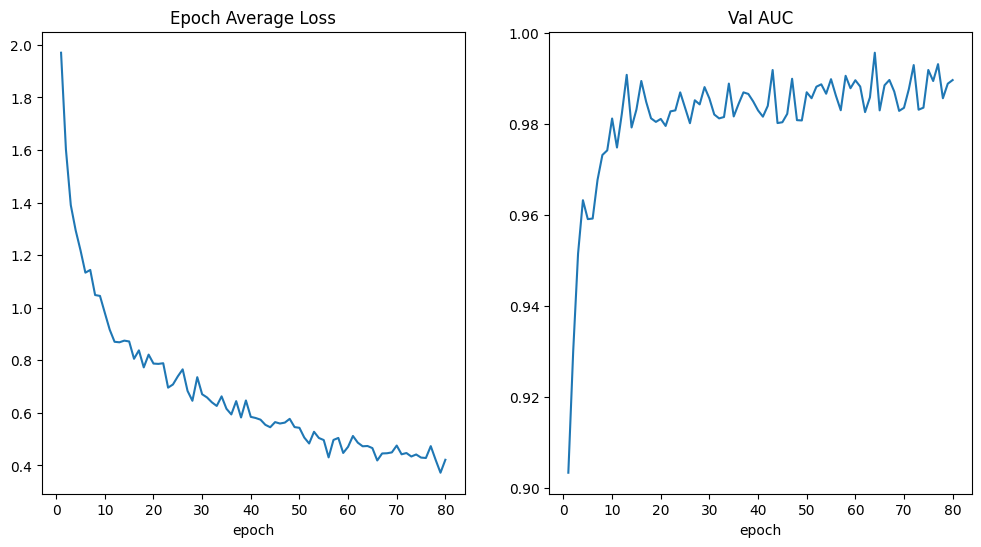

In [61]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [62]:
model.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [63]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.6316    0.1739    0.2727        69
           1     0.3250    0.1912    0.2407        68
           2     0.1500    0.0870    0.1101        69
           3     0.3590    0.2154    0.2692        65
           4     0.3036    0.2615    0.2810        65
           5     0.3546    0.7576    0.4831        66
           6     0.1842    0.2500    0.2121        28
           7     0.0000    0.0000    0.0000        21
           8     0.2857    0.0952    0.1429        21
           9     0.2302    0.4203    0.2974        69
          10     0.2421    0.3333    0.2805        69

    accuracy                         0.2836       610
   macro avg     0.2787    0.2532    0.2354       610
weighted avg     0.3053    0.2836    0.2611       610



In [64]:
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'sagittal_random_unpretrained_seed{seed}.csv')

In [65]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 190.75 MB
Max VRAM used during training: 245.22 MB


# Using 2d models as a backbone

In [66]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))

<All keys matched successfully>

In [67]:
class CombinedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        # Assuming each model outputs a 512-dimension feature vector (from ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):
        slice_axial = np.random.randint(4, 58, dtype=int)
        slice_coronal = np.random.randint(4, 58, dtype=int)
        slice_sagittal = np.random.randint(4, 58, dtype=int)
        
        axial = x[:, :, slice_axial-4:slice_axial+5, :, :][:, 0].to(torch.float32)
        coronal = x[:, :, :, slice_coronal-4:slice_coronal+5, :][:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal = x[:, :, :, :, slice_sagittal-4:slice_sagittal+5][:, 0].permute(0, 3, 1, 2).to(torch.float32)

        axial_features = self.model_axial(axial)  # Output: [batch_size, 512, 1, 1]
        coronal_features = self.model_coronal(coronal)
        sagittal_features = self.model_sagittal(sagittal)

        axial_features = axial_features.view(axial_features.size(0), -1)  # [batch_size, 512]
        coronal_features = coronal_features.view(coronal_features.size(0), -1)
        sagittal_features = sagittal_features.view(sagittal_features.size(0), -1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

## Evaluation on a 3d dataset

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [69]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [70]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [71]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.1483401560014292
Epoch 2, Loss: 1.4494961461713236
Epoch 3, Loss: 1.0011906143157714
Epoch 4, Loss: 0.7308161854743958
Epoch 5, Loss: 0.5646858138422812
Epoch 6, Loss: 0.4410305407739455
Epoch 7, Loss: 0.36764629617814093
Epoch 8, Loss: 0.3260049046047272
Epoch 9, Loss: 0.27213007115548654
Epoch 10, Loss: 0.25140724787789004
Epoch 11, Loss: 0.22213659459544766
Epoch 12, Loss: 0.1955424758695787
Epoch 13, Loss: 0.1972628173328215
Epoch 14, Loss: 0.1726057231426239
Epoch 15, Loss: 0.15994358206948928
Epoch 16, Loss: 0.1480981933493768
Epoch 17, Loss: 0.1396837902645911
Epoch 18, Loss: 0.13800156789441262
Epoch 19, Loss: 0.13624908654920517
Epoch 20, Loss: 0.14454671980873232
Epoch 21, Loss: 0.11501783949713554
Epoch 22, Loss: 0.10377685713671869
Epoch 23, Loss: 0.10886228457093239
Epoch 24, Loss: 0.09844503683909293
Epoch 25, Loss: 0.09812505026498149
Epoch 26, Loss: 0.09811850156514876
Epoch 27, Loss: 0.0956442638510658
Epoch 28, Loss: 0.08978378352138304
Epoch 29, Loss

In [72]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 50.11 seconds
CPU time used: 600.65 seconds
Memory used: 34.44 MB
GPU Memory Used: 392.28 MB
Max GPU Memory Used: 1119.08 MB


In [73]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 392.28 MB
Max VRAM used during training: 1119.08 MB


In [74]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 1.0000


In [75]:
combined_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = combined_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9960


In [76]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9857    1.0000    0.9928        69
           1     0.8889    0.8235    0.8550        68
           2     0.8382    0.8261    0.8321        69
           3     0.8462    0.8462    0.8462        65
           4     0.8143    0.8769    0.8444        65
           5     1.0000    0.9091    0.9524        66
           6     1.0000    1.0000    1.0000        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9571    0.9710    0.9640        69
          10     0.9324    1.0000    0.9650        69

    accuracy                         0.9180       610
   macro avg     0.9330    0.9321    0.9320       610
weighted avg     0.9190    0.9180    0.9179       610



In [77]:
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'combined_unpretrained_random_seed{seed}.csv')

In [78]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 392.90 MB
Max VRAM used during training: 1119.08 MB


### Pretrained

In [79]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [80]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(9, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [81]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [82]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

writer = SummaryWriter()
epochs = tqdm(range(30), desc="Epochs", leave=True, dynamic_ncols=True, ascii=True)

for epoch in epochs:
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    writer.add_scalar("train_loss", loss.item())
    epochs.set_postfix(train_loss=loss.item())
    tqdm.write(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|3         | 1/30 [00:01<00:43,  1.49s/it, train_loss=2.2]

Epoch 1, Loss: 2.344799330157618


Epochs:   7%|6         | 2/30 [00:02<00:39,  1.41s/it, train_loss=1.34]

Epoch 2, Loss: 1.7669302378931353


Epochs:  10%|#         | 3/30 [00:04<00:37,  1.38s/it, train_loss=1.21]

Epoch 3, Loss: 1.3473942395179503


Epochs:  13%|#3        | 4/30 [00:05<00:35,  1.37s/it, train_loss=1.16]

Epoch 4, Loss: 1.1055529444448409


Epochs:  17%|#6        | 5/30 [00:06<00:34,  1.36s/it, train_loss=0.828]

Epoch 5, Loss: 0.8936517315526162


Epochs:  20%|##        | 6/30 [00:08<00:32,  1.36s/it, train_loss=0.894]

Epoch 6, Loss: 0.8003303331713523


Epochs:  23%|##3       | 7/30 [00:09<00:31,  1.35s/it, train_loss=0.847]

Epoch 7, Loss: 0.7058608974179914


Epochs:  27%|##6       | 8/30 [00:10<00:29,  1.35s/it, train_loss=0.578]

Epoch 8, Loss: 0.6008223881644588


Epochs:  30%|###       | 9/30 [00:12<00:28,  1.35s/it, train_loss=0.713]

Epoch 9, Loss: 0.565179007668649


Epochs:  33%|###3      | 10/30 [00:13<00:27,  1.35s/it, train_loss=0.629]

Epoch 10, Loss: 0.5104654671684388


Epochs:  37%|###6      | 11/30 [00:14<00:25,  1.35s/it, train_loss=0.729]

Epoch 11, Loss: 0.46981988799187446


Epochs:  40%|####      | 12/30 [00:16<00:24,  1.35s/it, train_loss=0.372]

Epoch 12, Loss: 0.4529131545174506


Epochs:  43%|####3     | 13/30 [00:17<00:22,  1.35s/it, train_loss=0.524]

Epoch 13, Loss: 0.4308737458721284


Epochs:  47%|####6     | 14/30 [00:19<00:21,  1.35s/it, train_loss=0.419]

Epoch 14, Loss: 0.40128247680202606


Epochs:  50%|#####     | 15/30 [00:20<00:20,  1.35s/it, train_loss=0.241]

Epoch 15, Loss: 0.3742558701384452


Epochs:  53%|#####3    | 16/30 [00:21<00:18,  1.35s/it, train_loss=0.403]

Epoch 16, Loss: 0.37303618798332827


Epochs:  57%|#####6    | 17/30 [00:23<00:17,  1.35s/it, train_loss=0.387]

Epoch 17, Loss: 0.35082494779940576


Epochs:  60%|######    | 18/30 [00:24<00:16,  1.35s/it, train_loss=0.521]

Epoch 18, Loss: 0.33508340053019986


Epochs:  63%|######3   | 19/30 [00:25<00:14,  1.35s/it, train_loss=0.299]

Epoch 19, Loss: 0.2943374495352468


Epochs:  67%|######6   | 20/30 [00:27<00:13,  1.34s/it, train_loss=0.327]

Epoch 20, Loss: 0.30641191188366185


Epochs:  70%|#######   | 21/30 [00:28<00:12,  1.34s/it, train_loss=0.209]

Epoch 21, Loss: 0.3244877770062416


Epochs:  73%|#######3  | 22/30 [00:29<00:10,  1.34s/it, train_loss=0.24] 

Epoch 22, Loss: 0.2916384156673185


Epochs:  77%|#######6  | 23/30 [00:31<00:09,  1.34s/it, train_loss=0.472]

Epoch 23, Loss: 0.28771877697398585


Epochs:  80%|########  | 24/30 [00:32<00:08,  1.34s/it, train_loss=0.273]

Epoch 24, Loss: 0.2762724247670943


Epochs:  83%|########3 | 25/30 [00:33<00:06,  1.34s/it, train_loss=0.307]

Epoch 25, Loss: 0.27791202933557574


Epochs:  87%|########6 | 26/30 [00:35<00:05,  1.34s/it, train_loss=0.373]

Epoch 26, Loss: 0.24388534647803153


Epochs:  90%|######### | 27/30 [00:36<00:04,  1.34s/it, train_loss=0.131]

Epoch 27, Loss: 0.23977046435879124


Epochs:  93%|#########3| 28/30 [00:37<00:02,  1.34s/it, train_loss=0.379]

Epoch 28, Loss: 0.26136488827966875


Epochs:  97%|#########6| 29/30 [00:39<00:01,  1.34s/it, train_loss=0.332]

Epoch 29, Loss: 0.2633334205996606


Epochs: 100%|##########| 30/30 [00:40<00:00,  1.35s/it, train_loss=0.221]

Epoch 30, Loss: 0.2374926983348785


In [83]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 40.52 seconds
CPU time used: 485.56 seconds
Memory used: 15.44 MB
GPU Memory Used: 129.13 MB
Max GPU Memory Used: 594.37 MB


In [84]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 129.13 MB
Max VRAM used during training: 594.37 MB


In [85]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9994


In [86]:
combined_model.eval()
y_true = []
y_predicted = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = combined_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9872


In [87]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9444    0.9855    0.9645        69
           1     0.7627    0.6618    0.7087        68
           2     0.6875    0.6377    0.6617        69
           3     0.8167    0.7538    0.7840        65
           4     0.7910    0.8154    0.8030        65
           5     0.8857    0.9394    0.9118        66
           6     1.0000    0.8929    0.9434        28
           7     0.9545    1.0000    0.9767        21
           8     1.0000    0.9524    0.9756        21
           9     0.8630    0.9130    0.8873        69
          10     0.8718    0.9855    0.9252        69

    accuracy                         0.8492       610
   macro avg     0.8707    0.8670    0.8674       610
weighted avg     0.8462    0.8492    0.8462       610



In [88]:
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'combined_pretrained_random_seed{seed}.csv')

In [89]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 129.13 MB
Max VRAM used during training: 594.37 MB


## Balanced concatenation

In [90]:
def extract_metrics(file_path, has_auc=False):
    df = pd.read_csv(file_path)
    metrics = df.loc[df.index[-3], 'precision']
    return metrics

In [91]:
model_names = ['axial_random_unpretrained', 'coronal_random_unpretrained', 
               'sagittal_random_unpretrained']
csv_files = {
    model: glob.glob(reports_dir+f"{model}_seed{seed}.csv")
    for model in model_names
}

In [92]:
results = {}
for model, files in csv_files.items():
    model_metrics = []
    for file in files:
        metrics = extract_metrics(file)
    results[model] = metrics

In [93]:
results

{'axial_random_unpretrained': 0.8344262295081967,
 'coronal_random_unpretrained': 0.2491803278688524,
 'sagittal_random_unpretrained': 0.2836065573770492}

In [94]:
accuracies = list(results.values())
total_acc = sum(accuracies)
print([acc / total_acc for acc in accuracies])

[0.6103117505995204, 0.18225419664268583, 0.2074340527577938]


In [95]:
class BalancedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, accuracies, num_classes=n_classes):
        super(BalancedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        total_acc = sum(accuracies)
        self.weights = [acc / total_acc for acc in accuracies]
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        slice_axial = np.random.randint(4, 58, dtype=int)
        slice_coronal = np.random.randint(4, 58, dtype=int)
        slice_sagittal = np.random.randint(4, 58, dtype=int)
        
        axial = x[:, :, slice_axial-4:slice_axial+5, :, :][:, 0].to(torch.float32)
        coronal = x[:, :, :, slice_coronal-4:slice_coronal+5, :][:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal = x[:, :, :, :, slice_sagittal-4:slice_sagittal+5][:, 0].permute(0, 3, 1, 2).to(torch.float32)

        axial_features = self.model_axial(axial)  # Output: [batch_size, 512, 1, 1]
        coronal_features = self.model_coronal(coronal)
        sagittal_features = self.model_sagittal(sagittal)

        axial_features = axial_features.view(axial_features.size(0), -1)  # [batch_size, 512]
        coronal_features = coronal_features.view(coronal_features.size(0), -1)
        sagittal_features = sagittal_features.view(sagittal_features.size(0), -1)

        # Weights balancing
        weighted_features = (self.weights[0] * axial_features + self.weights[1] * coronal_features + 
                             self.weights[2] * sagittal_features)

        # Final classification
        out = self.fc(weighted_features)
        return out

In [96]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))

<All keys matched successfully>

In [97]:
train_loader_3d = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [98]:
balanced_model = BalancedResNetModel(model_axial, model_coronal, model_sagittal, accuracies=list(results.values()),
                                     num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(balanced_model.fc.parameters(), lr=0.0005)

In [99]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in range(30):
    balanced_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = balanced_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 1.34913604376746
Epoch 2, Loss: 0.5398012934649576
Epoch 3, Loss: 0.36534587324398465
Epoch 4, Loss: 0.28871161481518237
Epoch 5, Loss: 0.2239573542639369
Epoch 6, Loss: 0.21016142886803776
Epoch 7, Loss: 0.2079352645172936
Epoch 8, Loss: 0.1893281721219909
Epoch 9, Loss: 0.17727294206985686
Epoch 10, Loss: 0.15488636472308245
Epoch 11, Loss: 0.1722132489428718
Epoch 12, Loss: 0.1304700777438454
Epoch 13, Loss: 0.13811604045026127
Epoch 14, Loss: 0.15231657197286727
Epoch 15, Loss: 0.13340962923238756
Epoch 16, Loss: 0.1280424623276855
Epoch 17, Loss: 0.14619294179175965
Epoch 18, Loss: 0.11514809158569599
Epoch 19, Loss: 0.11281396723047021
Epoch 20, Loss: 0.13168694889917207
Epoch 21, Loss: 0.11710276297621856
Epoch 22, Loss: 0.10736640853059219
Epoch 23, Loss: 0.10724321391326605
Epoch 24, Loss: 0.11352320950951611
Epoch 25, Loss: 0.11635505095254019
Epoch 26, Loss: 0.1183425674184424
Epoch 27, Loss: 0.12692324614598888
Epoch 28, Loss: 0.1010399169114907
Epoch 29, Los

In [100]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 86.38 seconds
CPU time used: 1034.95 seconds
Memory used: 22.95 MB
GPU Memory Used: 375.81 MB
Max GPU Memory Used: 573.95 MB


In [101]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 375.81 MB
Max VRAM used during training: 573.95 MB


In [102]:
balanced_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = balanced_model(val_images.to(device), )
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 1.0000


In [103]:
balanced_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = balanced_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9946


In [104]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9857    1.0000    0.9928        69
           1     0.8500    0.7500    0.7969        68
           2     0.7794    0.7681    0.7737        69
           3     0.8714    0.9385    0.9037        65
           4     0.8939    0.9077    0.9008        65
           5     0.9524    0.9091    0.9302        66
           6     1.0000    1.0000    1.0000        28
           7     0.9545    1.0000    0.9767        21
           8     1.0000    0.9524    0.9756        21
           9     0.9178    0.9710    0.9437        69
          10     0.9571    0.9710    0.9640        69

    accuracy                         0.9115       610
   macro avg     0.9239    0.9243    0.9235       610
weighted avg     0.9108    0.9115    0.9105       610



In [105]:
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'balanced_unpretrained_random_seed{seed}.csv')

In [106]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 375.81 MB
Max VRAM used during training: 573.95 MB


### Pretrained

In [107]:
model_names = ['axial_random_pretrained', 'coronal_random_pretrained', 'sagittal_random_pretrained']
csv_files = {
    model: glob.glob(reports_dir+f"{model}_seed{seed}.csv")
    for model in model_names
}

In [108]:
results = {}
for model, files in csv_files.items():
    model_metrics = []
    for file in files:
        metrics = extract_metrics(file)
    results[model] = metrics

In [109]:
accuracies = list(results.values())
total_acc = sum(accuracies)
print([acc / total_acc for acc in accuracies])

[0.33088725817211473, 0.36357571714476317, 0.30553702468312205]


In [110]:
# Load the pretrained models for each slice direction
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(9, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [111]:
train_loader_3d = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [112]:
balanced_model = BalancedResNetModel(model_axial, model_coronal, model_sagittal, accuracies=list(results.values()),
                                     num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(balanced_model.fc.parameters(), lr=0.0005)

In [113]:
# start_time = time.time()
# process = psutil.Process()
# start_cpu = process.cpu_times()
# start_mem = process.memory_info().rss / 1024**2  # В MB

# if device.type == "cuda":
#     torch.cuda.synchronize()
#     torch.cuda.reset_peak_memory_stats()

for epoch in range(30):
    balanced_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = balanced_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 1.6338059100948397
Epoch 2, Loss: 0.9304469003052008
Epoch 3, Loss: 0.7925616722615039
Epoch 4, Loss: 0.694320344045514
Epoch 5, Loss: 0.6261171210007589
Epoch 6, Loss: 0.6362876994688003
Epoch 7, Loss: 0.5801853762298333
Epoch 8, Loss: 0.586406348425834
Epoch 9, Loss: 0.5633698628574121
Epoch 10, Loss: 0.5516399433378314
Epoch 11, Loss: 0.5555966090960581
Epoch 12, Loss: 0.5245883481912925
Epoch 13, Loss: 0.49781261408915284
Epoch 14, Loss: 0.5053144703145886
Epoch 15, Loss: 0.4879818827402396
Epoch 16, Loss: 0.5008185210286594
Epoch 17, Loss: 0.4769276673676538
Epoch 18, Loss: 0.49824970325485607
Epoch 19, Loss: 0.44889750148429247
Epoch 20, Loss: 0.4434149917520461
Epoch 21, Loss: 0.4795299477753092
Epoch 22, Loss: 0.4427736533469841
Epoch 23, Loss: 0.46252833893064593
Epoch 24, Loss: 0.432012067710767
Epoch 25, Loss: 0.416605145471995
Epoch 26, Loss: 0.44178358550931585
Epoch 27, Loss: 0.43393157019478373
Epoch 28, Loss: 0.4057523819511054
Epoch 29, Loss: 0.427544916

In [114]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 142.30 seconds
CPU time used: 1703.84 seconds
Memory used: 41.47 MB
GPU Memory Used: 216.31 MB
Max GPU Memory Used: 573.95 MB


In [115]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 216.31 MB
Max VRAM used during training: 573.95 MB


In [116]:
balanced_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = balanced_model(val_images.to(device), )
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9960


In [117]:
balanced_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = balanced_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9795


In [118]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9851    0.9565    0.9706        69
           1     0.7115    0.5441    0.6167        68
           2     0.5111    0.6667    0.5786        69
           3     0.7051    0.8462    0.7692        65
           4     0.7333    0.6769    0.7040        65
           5     0.8310    0.8939    0.8613        66
           6     0.9615    0.8929    0.9259        28
           7     0.9545    1.0000    0.9767        21
           8     1.0000    0.9524    0.9756        21
           9     0.9344    0.8261    0.8769        69
          10     0.8730    0.7971    0.8333        69

    accuracy                         0.7951       610
   macro avg     0.8364    0.8230    0.8263       610
weighted avg     0.8076    0.7951    0.7973       610



In [119]:
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'balanced_pretrained_random_seed{seed}.csv')

In [120]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 216.31 MB
Max VRAM used during training: 573.95 MB


## Weighted concatenation

In [121]:
class HyperNetwork(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=11):
        super(HyperNetwork, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])
        
        # Hypernetwork for weighting the features
        self.hyper_fc = nn.Sequential(
            nn.Linear(512 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 512 * 3),
            nn.Sigmoid()
        )
        
        # Final classification layer
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, x):
        slice_axial = np.random.randint(4, 58, dtype=int)
        slice_coronal = np.random.randint(4, 58, dtype=int)
        slice_sagittal = np.random.randint(4, 58, dtype=int)
        
        axial = x[:, :, slice_axial-4:slice_axial+5, :, :][:, 0].to(torch.float32)
        coronal = x[:, :, :, slice_coronal-4:slice_coronal+5, :][:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal = x[:, :, :, :, slice_sagittal-4:slice_sagittal+5][:, 0].permute(0, 3, 1, 2).to(torch.float32)
        
        features_axial = self.model_axial(axial).flatten(1)
        features_coronal = self.model_coronal(coronal).flatten(1)
        features_sagittal = self.model_sagittal(sagittal).flatten(1)
        
        combined_features = torch.cat([features_axial, features_coronal, features_sagittal], dim=1)
        
        # Apply hypernetwork to decide weights
        weights = self.hyper_fc(combined_features)
        combined_weighted_features = combined_features * weights
        
        # Final classification
        out = self.fc(combined_weighted_features)
        return out

In [122]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [124]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=9, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))

<All keys matched successfully>

In [125]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [126]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(30), desc="Epochs"):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(torch.float32).to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|▎         | 1/30 [00:01<00:48,  1.66s/it]

Epoch 1, Loss: 2.2112771003477034


Epochs:   7%|▋         | 2/30 [00:03<00:46,  1.66s/it]

Epoch 2, Loss: 1.7947637419546805


Epochs:  10%|█         | 3/30 [00:04<00:44,  1.66s/it]

Epoch 3, Loss: 1.473106272758976


Epochs:  13%|█▎        | 4/30 [00:06<00:43,  1.66s/it]

Epoch 4, Loss: 1.220035522214828


Epochs:  17%|█▋        | 5/30 [00:08<00:41,  1.66s/it]

Epoch 5, Loss: 1.024761386456028


Epochs:  20%|██        | 6/30 [00:09<00:39,  1.66s/it]

Epoch 6, Loss: 0.8619388976404744


Epochs:  23%|██▎       | 7/30 [00:11<00:38,  1.66s/it]

Epoch 7, Loss: 0.727765598604756


Epochs:  27%|██▋       | 8/30 [00:13<00:36,  1.66s/it]

Epoch 8, Loss: 0.6254553564133183


Epochs:  30%|███       | 9/30 [00:14<00:34,  1.66s/it]

Epoch 9, Loss: 0.5572374116989874


Epochs:  33%|███▎      | 10/30 [00:16<00:33,  1.66s/it]

Epoch 10, Loss: 0.4929782873199832


Epochs:  37%|███▋      | 11/30 [00:18<00:31,  1.66s/it]

Epoch 11, Loss: 0.42914964402875594


Epochs:  40%|████      | 12/30 [00:19<00:29,  1.66s/it]

Epoch 12, Loss: 0.40732886618183506


Epochs:  43%|████▎     | 13/30 [00:21<00:28,  1.66s/it]

Epoch 13, Loss: 0.36391605292597123


Epochs:  47%|████▋     | 14/30 [00:23<00:26,  1.66s/it]

Epoch 14, Loss: 0.3420551880713432


Epochs:  50%|█████     | 15/30 [00:24<00:24,  1.66s/it]

Epoch 15, Loss: 0.3114080539634151


Epochs:  53%|█████▎    | 16/30 [00:26<00:23,  1.66s/it]

Epoch 16, Loss: 0.28429731582441636


Epochs:  57%|█████▋    | 17/30 [00:28<00:21,  1.66s/it]

Epoch 17, Loss: 0.2763063234667624


Epochs:  60%|██████    | 18/30 [00:29<00:19,  1.66s/it]

Epoch 18, Loss: 0.24872788354273764


Epochs:  63%|██████▎   | 19/30 [00:31<00:18,  1.66s/it]

Epoch 19, Loss: 0.24497574135180442


Epochs:  67%|██████▋   | 20/30 [00:33<00:16,  1.66s/it]

Epoch 20, Loss: 0.22681380568012113


Epochs:  70%|███████   | 21/30 [00:34<00:14,  1.66s/it]

Epoch 21, Loss: 0.2136321976300209


Epochs:  73%|███████▎  | 22/30 [00:36<00:13,  1.66s/it]

Epoch 22, Loss: 0.2124197377312568


Epochs:  77%|███████▋  | 23/30 [00:38<00:11,  1.66s/it]

Epoch 23, Loss: 0.19400261198320695


Epochs:  80%|████████  | 24/30 [00:39<00:09,  1.66s/it]

Epoch 24, Loss: 0.1865873757389284


Epochs:  83%|████████▎ | 25/30 [00:41<00:08,  1.66s/it]

Epoch 25, Loss: 0.17084679872758926


Epochs:  87%|████████▋ | 26/30 [00:43<00:06,  1.66s/it]

Epoch 26, Loss: 0.17207614524710563


Epochs:  90%|█████████ | 27/30 [00:44<00:04,  1.66s/it]

Epoch 27, Loss: 0.17467250098143855


Epochs:  93%|█████████▎| 28/30 [00:46<00:03,  1.66s/it]

Epoch 28, Loss: 0.16828385428074868


Epochs:  97%|█████████▋| 29/30 [00:48<00:01,  1.66s/it]

Epoch 29, Loss: 0.15262718090126592


Epochs: 100%|██████████| 30/30 [00:49<00:00,  1.66s/it]

Epoch 30, Loss: 0.15436089375326711


In [127]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 49.84 seconds
CPU time used: 597.10 seconds
Memory used: 24.64 MB
GPU Memory Used: 465.02 MB
Max GPU Memory Used: 1164.33 MB


In [128]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 465.02 MB
Max VRAM used during training: 1164.33 MB


In [129]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(torch.float32).to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric = ROCAUCMetric()
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9999


In [130]:
hypernetwork.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = hypernetwork(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9967


In [131]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict = True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        69
           1     0.8889    0.8235    0.8550        68
           2     0.8406    0.8406    0.8406        69
           3     0.8533    0.9846    0.9143        65
           4     0.9483    0.8462    0.8943        65
           5     0.9697    0.9697    0.9697        66
           6     1.0000    0.9286    0.9630        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9306    0.9710    0.9504        69
          10     0.9714    0.9855    0.9784        69

    accuracy                         0.9328       610
   macro avg     0.9457    0.9409    0.9423       610
weighted avg     0.9341    0.9328    0.9324       610



In [132]:
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'weighted_unpretrained_random_seed{seed}.csv')

In [133]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 465.02 MB
Max VRAM used during training: 1164.33 MB


### Pretrained

In [134]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(9, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [135]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [136]:
start_time = time.time()
process = psutil.Process()
start_cpu = process.cpu_times()
start_mem = process.memory_info().rss / 1024**2  # В MB

if device.type == "cuda":
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()

for epoch in tqdm(range(30), desc="Epochs"):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(torch.float32).to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|▎         | 1/30 [00:01<00:39,  1.37s/it]

Epoch 1, Loss: 2.1681619921038227


Epochs:   7%|▋         | 2/30 [00:02<00:38,  1.37s/it]

Epoch 2, Loss: 1.8623841116505284


Epochs:  10%|█         | 3/30 [00:04<00:36,  1.37s/it]

Epoch 3, Loss: 1.6308510072769657


Epochs:  13%|█▎        | 4/30 [00:05<00:35,  1.37s/it]

Epoch 4, Loss: 1.4028453365448983


Epochs:  17%|█▋        | 5/30 [00:06<00:34,  1.37s/it]

Epoch 5, Loss: 1.2376108169555664


Epochs:  20%|██        | 6/30 [00:08<00:32,  1.37s/it]

Epoch 6, Loss: 1.1045384791589552


Epochs:  23%|██▎       | 7/30 [00:09<00:31,  1.37s/it]

Epoch 7, Loss: 1.006035812439457


Epochs:  27%|██▋       | 8/30 [00:10<00:30,  1.37s/it]

Epoch 8, Loss: 0.904598141870191


Epochs:  30%|███       | 9/30 [00:12<00:28,  1.37s/it]

Epoch 9, Loss: 0.8282707160519015


Epochs:  33%|███▎      | 10/30 [00:13<00:27,  1.37s/it]

Epoch 10, Loss: 0.7871423306003693


Epochs:  37%|███▋      | 11/30 [00:15<00:26,  1.37s/it]

Epoch 11, Loss: 0.6964666804959697


Epochs:  40%|████      | 12/30 [00:16<00:24,  1.37s/it]

Epoch 12, Loss: 0.6804731892001245


Epochs:  43%|████▎     | 13/30 [00:17<00:23,  1.37s/it]

Epoch 13, Loss: 0.6199642160246449


Epochs:  47%|████▋     | 14/30 [00:19<00:21,  1.37s/it]

Epoch 14, Loss: 0.6035871053895643


Epochs:  50%|█████     | 15/30 [00:20<00:20,  1.37s/it]

Epoch 15, Loss: 0.5726237941172815


Epochs:  53%|█████▎    | 16/30 [00:21<00:19,  1.37s/it]

Epoch 16, Loss: 0.5354071172975725


Epochs:  57%|█████▋    | 17/30 [00:23<00:17,  1.37s/it]

Epoch 17, Loss: 0.5210716109121999


Epochs:  60%|██████    | 18/30 [00:24<00:16,  1.37s/it]

Epoch 18, Loss: 0.4919022581269664


Epochs:  63%|██████▎   | 19/30 [00:25<00:15,  1.37s/it]

Epoch 19, Loss: 0.48619132657204905


Epochs:  67%|██████▋   | 20/30 [00:27<00:13,  1.37s/it]

Epoch 20, Loss: 0.4659293284339289


Epochs:  70%|███████   | 21/30 [00:28<00:12,  1.37s/it]

Epoch 21, Loss: 0.45585656262213187


Epochs:  73%|███████▎  | 22/30 [00:30<00:10,  1.37s/it]

Epoch 22, Loss: 0.43065799436261576


Epochs:  77%|███████▋  | 23/30 [00:31<00:09,  1.37s/it]

Epoch 23, Loss: 0.40840418781003646


Epochs:  80%|████████  | 24/30 [00:32<00:08,  1.37s/it]

Epoch 24, Loss: 0.3759979086537515


Epochs:  83%|████████▎ | 25/30 [00:34<00:06,  1.37s/it]

Epoch 25, Loss: 0.38033972920910003


Epochs:  87%|████████▋ | 26/30 [00:35<00:05,  1.37s/it]

Epoch 26, Loss: 0.38593683992662736


Epochs:  90%|█████████ | 27/30 [00:36<00:04,  1.37s/it]

Epoch 27, Loss: 0.3808960578133983


Epochs:  93%|█████████▎| 28/30 [00:38<00:02,  1.37s/it]

Epoch 28, Loss: 0.3506175039276


Epochs:  97%|█████████▋| 29/30 [00:39<00:01,  1.37s/it]

Epoch 29, Loss: 0.3679370817638213


Epochs: 100%|██████████| 30/30 [00:41<00:00,  1.37s/it]

Epoch 30, Loss: 0.3320913588808429


In [137]:
end_time = time.time()
end_cpu = process.cpu_times()
end_mem = process.memory_info().rss / 1024**2

cpu_time = (end_cpu.user + end_cpu.system) - (start_cpu.user + start_cpu.system)
memory_used = end_mem - start_mem

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"CPU time used: {cpu_time:.2f} seconds")
print(f"Memory used: {memory_used:.2f} MB")

if device.type == "cuda":
    torch.cuda.synchronize()
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max GPU Memory Used: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")


Training time: 41.04 seconds
CPU time used: 491.94 seconds
Memory used: -31.36 MB
GPU Memory Used: 287.63 MB
Max GPU Memory Used: 726.88 MB


In [138]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 287.63 MB
Max VRAM used during training: 726.88 MB


In [139]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(torch.float32).to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9990


In [140]:
hypernetwork.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = hypernetwork(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9879


In [141]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict = True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9583    1.0000    0.9787        69
           1     0.7536    0.7647    0.7591        68
           2     0.8364    0.6667    0.7419        69
           3     0.6735    0.5077    0.5789        65
           4     0.6341    0.8000    0.7075        65
           5     0.8889    0.9697    0.9275        66
           6     1.0000    0.8571    0.9231        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.9853    0.9710    0.9781        69
          10     0.8831    0.9855    0.9315        69

    accuracy                         0.8475       610
   macro avg     0.8739    0.8657    0.8660       610
weighted avg     0.8486    0.8475    0.8439       610



In [142]:
df = pd.DataFrame(report).transpose()
df.to_csv(reports_dir+f'weighted_pretrained_random_seed{seed}.csv')

In [143]:
if device.type == "cuda":
    torch.cuda.synchronize()
    vram_used = torch.cuda.memory_allocated() / 1024**2
    vram_max_used = torch.cuda.max_memory_allocated() / 1024**2

    print(f"VRAM currently used: {vram_used:.2f} MB")
    print(f"Max VRAM used during training: {vram_max_used:.2f} MB")


VRAM currently used: 287.63 MB
Max VRAM used during training: 726.88 MB
